In [89]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm

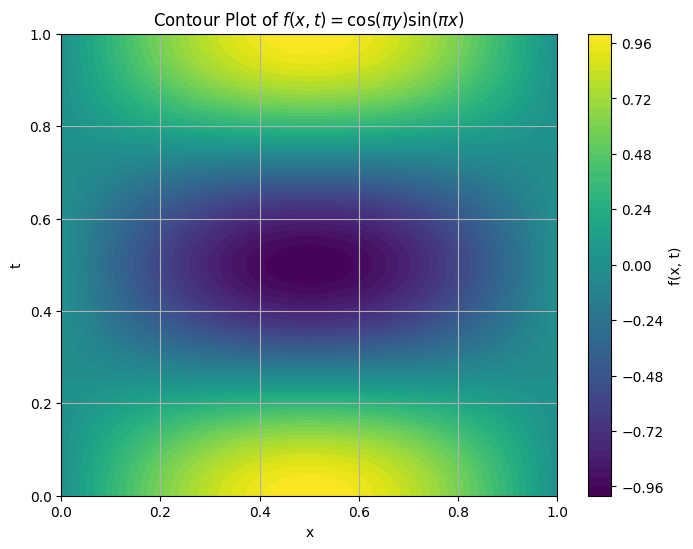

In [92]:
c = 2
l = 1

def u_ana(x, t):
    return np.cos(np.pi * t * c * (1/l)) * np.sin(np.pi * x * (1/l))

# Create a grid of x and y values
x = np.linspace(0, 1, 400)
t = np.linspace(0, 1, 400)
X, T = np.meshgrid(x, t)
U = u_ana(X, T)

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, T, U, levels=50, cmap='viridis')
plt.colorbar(contour, label='f(x, t)')
plt.title(r'Contour Plot of $f(x, t) = \cos(\pi y) \sin(\pi x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.grid(True)
plt.show()


In [103]:
import numpy as np
import torch.nn as nn


def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower

get_data([0, 1], [0, 1], 10, 10)[4]


array([[0.        , 0.        ],
       [0.        , 0.11111111],
       [0.        , 0.22222222],
       [0.        , 0.33333333],
       [0.        , 0.44444444],
       [0.        , 0.55555556],
       [0.        , 0.66666667],
       [0.        , 0.77777778],
       [0.        , 0.88888889],
       [0.        , 1.        ]])

In [57]:
class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()

        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(nn.Tanh())
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(nn.Tanh())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        return self.linear(src)

In [58]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [60]:
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [83]:
model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr=1e-4)


/var/folders/pj/hzntchlx2j34g96rbgzm14q00000gn/T/ipykernel_73814/1050756099.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [ ]:
loss_track = []
pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

for i in tqdm(range(100)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
        loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

        ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left), retain_graph=True, create_graph=True)[0]

        loss_ic_1 = torch.mean((pred_left[:,0] - torch.sin(pi*x_left[:,0])) ** 2)
        loss_ic_2 = torch.mean((ui_t)**2)

        loss_ic = loss_ic_1 + loss_ic_2

        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
        
        print(f"Loss Residual: {loss_res.item()} Loss IC: {loss_ic.item()} Loss BC: {loss_bc.item()}")

        loss = loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss Residual: 4.17636038037017e-05 Loss IC: 0.4941326975822449 Loss BC: 0.004176369868218899
Loss Residual: 4.475698369788006e-05 Loss IC: 0.4787693917751312 Loss BC: 0.0030005620792508125
Loss Residual: 0.00023826923279557377 Loss IC: 0.35466158390045166 Loss BC: 0.025752633810043335
Loss Residual: 0.0004971864400431514 Loss IC: 0.27552059292793274 Loss BC: 0.07360146194696426
Loss Residual: 0.0004563882830552757 Loss IC: 0.26097115874290466 Loss BC: 0.08002077043056488
Loss Residual: 0.00018092319078277797 Loss IC: 0.25460171699523926 Loss BC: 0.0764370858669281
Loss Residual: 7.034548616502434e-05 Loss IC: 0.25334039330482483 Loss BC: 0.07586528360843658
Loss Residual: 6.492770626209676e-05 Loss IC: 0.25840556621551514 Loss BC: 0.07073475420475006
Loss Residual: 6.623314402531832e-05 Loss IC: 0.2571571171283722 Loss BC: 0.07196874916553497
Loss Residual: 6.652128649875522e-05 Loss IC: 0.2571098208427429 Loss BC: 0.07201433926820755
Loss Residual: 6.934439443284646e-05 Loss IC: 0.25

  1%|          | 1/100 [00:09<15:55,  9.65s/it]

Loss Residual: 0.005525664892047644 Loss IC: 0.23750077188014984 Loss BC: 0.07351989299058914
Loss Residual: 0.11368552595376968 Loss IC: 0.1531040519475937 Loss BC: 0.1675911247730255
Loss Residual: 0.013041175901889801 Loss IC: 0.21100933849811554 Loss BC: 0.08815865963697433
Loss Residual: 0.008326495066285133 Loss IC: 0.18898078799247742 Loss BC: 0.09130839258432388
Loss Residual: 21376.744140625 Loss IC: 828.1783447265625 Loss BC: 691.294677734375
Loss Residual: 10.757654190063477 Loss IC: 12.298195838928223 Loss BC: 0.9352641105651855
Loss Residual: 0.12749223411083221 Loss IC: 0.28127413988113403 Loss BC: 0.1696050465106964
Loss Residual: 0.004627297632396221 Loss IC: 0.16673630475997925 Loss BC: 0.1048910990357399
Loss Residual: 0.0051843347027897835 Loss IC: 0.2097724974155426 Loss BC: 0.062104471027851105
Loss Residual: 0.004822258371859789 Loss IC: 0.18624074757099152 Loss BC: 0.07903807610273361
Loss Residual: 0.005327754188328981 Loss IC: 0.17377209663391113 Loss BC: 0.086

  2%|▏         | 2/100 [00:19<16:22, 10.02s/it]

Loss Residual: 0.003533206647261977 Loss IC: 0.1450953632593155 Loss BC: 0.10141876339912415
Loss Residual: 0.006269983947277069 Loss IC: 0.14369602501392365 Loss BC: 0.09859997034072876
Loss Residual: 0.0047802915796637535 Loss IC: 0.146731436252594 Loss BC: 0.09700566530227661
Loss Residual: 0.003914575092494488 Loss IC: 0.14590618014335632 Loss BC: 0.09743271768093109
Loss Residual: 0.00451624346897006 Loss IC: 0.14612971246242523 Loss BC: 0.09628546237945557
Loss Residual: 0.004599647596478462 Loss IC: 0.14763638377189636 Loss BC: 0.09432402998209
Loss Residual: 0.00462793093174696 Loss IC: 0.1493314951658249 Loss BC: 0.09152360260486603
Loss Residual: 0.004672355484217405 Loss IC: 0.15171091258525848 Loss BC: 0.08709142357110977
Loss Residual: 0.005303965415805578 Loss IC: 0.14916063845157623 Loss BC: 0.08723414689302444
Loss Residual: 0.004133416805416346 Loss IC: 0.1435365229845047 Loss BC: 0.09159708023071289
Loss Residual: 0.005620646756142378 Loss IC: 0.14021863043308258 Loss

  3%|▎         | 3/100 [00:30<16:39, 10.30s/it]

Loss Residual: 0.004308065865188837 Loss IC: 0.11882380396127701 Loss BC: 0.0995301827788353
Loss Residual: 0.004102793522179127 Loss IC: 0.12023705244064331 Loss BC: 0.09762312471866608
Loss Residual: 0.0041725714690983295 Loss IC: 0.12322984635829926 Loss BC: 0.09413540363311768
Loss Residual: 0.0038030685391277075 Loss IC: 0.12242520600557327 Loss BC: 0.09515078365802765
Loss Residual: 0.003957015927881002 Loss IC: 0.12229534983634949 Loss BC: 0.09490183740854263
Loss Residual: 0.004284994211047888 Loss IC: 0.12055383622646332 Loss BC: 0.09571091085672379
Loss Residual: 0.005241343751549721 Loss IC: 0.11984238773584366 Loss BC: 0.0925050675868988
Loss Residual: 0.007581797894090414 Loss IC: 0.12511448562145233 Loss BC: 0.07923862338066101
Loss Residual: 0.02012147754430771 Loss IC: 0.1280944049358368 Loss BC: 0.08250947296619415
Loss Residual: 0.006063300650566816 Loss IC: 0.12625382840633392 Loss BC: 0.07664228230714798
Loss Residual: 0.0038520130328834057 Loss IC: 0.12603864073753

  4%|▍         | 4/100 [00:41<17:02, 10.65s/it]

Loss Residual: 0.015908431261777878 Loss IC: 0.10002124309539795 Loss BC: 0.06833489239215851
Loss Residual: 0.016169443726539612 Loss IC: 0.09651999175548553 Loss BC: 0.06956740468740463
Loss Residual: 0.018842382356524467 Loss IC: 0.09014023095369339 Loss BC: 0.0702546089887619
Loss Residual: 0.023396525532007217 Loss IC: 0.08342479914426804 Loss BC: 0.07088886201381683
Loss Residual: 0.020160116255283356 Loss IC: 0.08620608597993851 Loss BC: 0.0697990208864212
Loss Residual: 0.015661273151636124 Loss IC: 0.0888248160481453 Loss BC: 0.06882862001657486
Loss Residual: 0.017776403576135635 Loss IC: 0.0853823721408844 Loss BC: 0.06617529690265656
Loss Residual: 0.017763830721378326 Loss IC: 0.08722610771656036 Loss BC: 0.060840290039777756
Loss Residual: 0.025885529816150665 Loss IC: 0.07643607258796692 Loss BC: 0.06931854039430618
Loss Residual: 0.01886693760752678 Loss IC: 0.08321070671081543 Loss BC: 0.06244784593582153
Loss Residual: 0.016650624573230743 Loss IC: 0.08364379405975342

  5%|▌         | 5/100 [00:53<17:20, 10.95s/it]

Loss Residual: 0.019157977774739265 Loss IC: 0.059120409190654755 Loss BC: 0.060075074434280396
Loss Residual: 0.018165504559874535 Loss IC: 0.06823272258043289 Loss BC: 0.050268009305000305
Loss Residual: 0.020196596160531044 Loss IC: 0.06520740687847137 Loss BC: 0.05035840719938278
Loss Residual: 0.018699081614613533 Loss IC: 0.064429871737957 Loss BC: 0.05237656459212303
Loss Residual: 0.018501020967960358 Loss IC: 0.06543479114770889 Loss BC: 0.05117679387331009
Loss Residual: 0.018584636971354485 Loss IC: 0.06573045253753662 Loss BC: 0.05044703185558319
Loss Residual: 0.018247250467538834 Loss IC: 0.06658294796943665 Loss BC: 0.04879649728536606
Loss Residual: 0.016154495999217033 Loss IC: 0.067691370844841 Loss BC: 0.04747816175222397
Loss Residual: 0.013309805653989315 Loss IC: 0.06736401468515396 Loss BC: 0.046187546104192734
Loss Residual: 0.010867844335734844 Loss IC: 0.06271276623010635 Loss BC: 0.04830499738454819
Loss Residual: 0.008874916471540928 Loss IC: 0.0604005418717

  6%|▌         | 6/100 [01:04<17:20, 11.07s/it]

Loss Residual: 0.007562213111668825 Loss IC: 0.05077333375811577 Loss BC: 0.043642111122608185
Loss Residual: 0.006586277391761541 Loss IC: 0.04759199544787407 Loss BC: 0.046022869646549225
Loss Residual: 0.005650174338370562 Loss IC: 0.04752763733267784 Loss BC: 0.04568712040781975
Loss Residual: 0.005432607606053352 Loss IC: 0.04514339566230774 Loss BC: 0.04651293158531189
Loss Residual: 0.004940465092658997 Loss IC: 0.045869626104831696 Loss BC: 0.04448433965444565
Loss Residual: 0.005024876445531845 Loss IC: 0.04574159160256386 Loss BC: 0.043289802968502045
Loss Residual: 0.0054846941493451595 Loss IC: 0.0447835735976696 Loss BC: 0.04275057092308998
Loss Residual: 0.006099284160882235 Loss IC: 0.04257548600435257 Loss BC: 0.04348950460553169
Loss Residual: 0.006999562028795481 Loss IC: 0.040921829640865326 Loss BC: 0.043585240840911865
Loss Residual: 0.00666485819965601 Loss IC: 0.04098143428564072 Loss BC: 0.04332347586750984
Loss Residual: 0.006521040573716164 Loss IC: 0.04010662

  7%|▋         | 7/100 [01:14<16:34, 10.70s/it]

Loss Residual: 0.006360301282256842 Loss IC: 0.032336656004190445 Loss BC: 0.04463496059179306
Loss Residual: 0.006660970859229565 Loss IC: 0.031387291848659515 Loss BC: 0.0448034405708313
Loss Residual: 0.006734606809914112 Loss IC: 0.03076212853193283 Loss BC: 0.044867366552352905
Loss Residual: 0.007580622099339962 Loss IC: 0.029490187764167786 Loss BC: 0.04543174058198929
Loss Residual: 0.007015759591013193 Loss IC: 0.030057869851589203 Loss BC: 0.045053258538246155
Loss Residual: 0.007351944223046303 Loss IC: 0.029905129224061966 Loss BC: 0.04459303617477417
Loss Residual: 0.007393913809210062 Loss IC: 0.029813658446073532 Loss BC: 0.04454515129327774
Loss Residual: 0.007388484664261341 Loss IC: 0.02991854026913643 Loss BC: 0.04435962438583374
Loss Residual: 0.007345878053456545 Loss IC: 0.02993926592171192 Loss BC: 0.04433227702975273
Loss Residual: 0.007146432995796204 Loss IC: 0.030356112867593765 Loss BC: 0.04400606080889702
Loss Residual: 0.006750772707164288 Loss IC: 0.03072

  8%|▊         | 8/100 [01:26<16:57, 11.06s/it]

Loss Residual: 0.005763784516602755 Loss IC: 0.025579921901226044 Loss BC: 0.04563929885625839
Loss Residual: 0.00565358018502593 Loss IC: 0.025381051003932953 Loss BC: 0.045634619891643524
Loss Residual: 0.005391246639192104 Loss IC: 0.025523869320750237 Loss BC: 0.045456018298864365
Loss Residual: 0.00512417359277606 Loss IC: 0.025011077523231506 Loss BC: 0.0458124503493309
Loss Residual: 0.004593309946358204 Loss IC: 0.024454178288578987 Loss BC: 0.04618391394615173
Loss Residual: 0.003932217136025429 Loss IC: 0.02381390519440174 Loss BC: 0.04650290310382843
Loss Residual: 0.0035633158404380083 Loss IC: 0.023478999733924866 Loss BC: 0.046676088124513626
Loss Residual: 0.0036398805677890778 Loss IC: 0.023648390546441078 Loss BC: 0.04614999145269394
Loss Residual: 0.0036872883792966604 Loss IC: 0.0235089473426342 Loss BC: 0.04604703560471535
Loss Residual: 0.0037719940301030874 Loss IC: 0.023191407322883606 Loss BC: 0.046052493155002594
Loss Residual: 0.0038748327642679214 Loss IC: 0.

  9%|▉         | 9/100 [01:36<16:28, 10.86s/it]

Loss Residual: 0.002724419580772519 Loss IC: 0.0234503373503685 Loss BC: 0.04447544738650322
Loss Residual: 0.0026518215890973806 Loss IC: 0.022992046549916267 Loss BC: 0.04485669732093811
Loss Residual: 0.002595231169834733 Loss IC: 0.02238187938928604 Loss BC: 0.04530114307999611
Loss Residual: 0.002199631417170167 Loss IC: 0.021183351054787636 Loss BC: 0.04648267477750778
Loss Residual: 0.0023691782262176275 Loss IC: 0.02006201632320881 Loss BC: 0.0472167506814003
Loss Residual: 0.002225755713880062 Loss IC: 0.02058674581348896 Loss BC: 0.04657146707177162
Loss Residual: 0.002263840986415744 Loss IC: 0.020980356261134148 Loss BC: 0.04599655792117119
Loss Residual: 0.0022950004786252975 Loss IC: 0.020582355558872223 Loss BC: 0.04627063125371933
Loss Residual: 0.002354765310883522 Loss IC: 0.020274151116609573 Loss BC: 0.04649088531732559
Loss Residual: 0.002353401854634285 Loss IC: 0.02012684941291809 Loss BC: 0.04662363603711128
Loss Residual: 0.0023653937969356775 Loss IC: 0.019877

 10%|█         | 10/100 [01:46<15:41, 10.46s/it]

Loss Residual: 0.0026416098698973656 Loss IC: 0.01901032030582428 Loss BC: 0.04501064866781235
Loss Residual: 0.0028093031141906977 Loss IC: 0.018485816195607185 Loss BC: 0.04517170041799545
Loss Residual: 0.0030473044607788324 Loss IC: 0.017493341118097305 Loss BC: 0.04580207169055939
Loss Residual: 0.003060049843043089 Loss IC: 0.017865939065814018 Loss BC: 0.04527682065963745
Loss Residual: 0.0028902741614729166 Loss IC: 0.018083039671182632 Loss BC: 0.04503834620118141
Loss Residual: 0.00276774144731462 Loss IC: 0.017786670476198196 Loss BC: 0.04514501243829727
Loss Residual: 0.002098271856084466 Loss IC: 0.01780109852552414 Loss BC: 0.0449727401137352
Loss Residual: 0.0019010299583896995 Loss IC: 0.017218584194779396 Loss BC: 0.045351359993219376
Loss Residual: 0.0015193382278084755 Loss IC: 0.017412129789590836 Loss BC: 0.04520971700549126
Loss Residual: 0.0016351562226191163 Loss IC: 0.017304811626672745 Loss BC: 0.044932764023542404
Loss Residual: 0.0016152657335624099 Loss IC:

 11%|█         | 11/100 [01:55<14:57, 10.08s/it]

Loss Residual: 0.0014435624470934272 Loss IC: 0.01546888705343008 Loss BC: 0.04503187537193298
Loss Residual: 0.0012911007506772876 Loss IC: 0.015074650757014751 Loss BC: 0.04533564671874046
Loss Residual: 0.0009832725627347827 Loss IC: 0.014718614518642426 Loss BC: 0.04565782472491264
Loss Residual: 0.0010923920199275017 Loss IC: 0.013845830224454403 Loss BC: 0.046559084206819534
Loss Residual: 0.0009801016421988606 Loss IC: 0.014347009360790253 Loss BC: 0.04597946256399155
Loss Residual: 0.001016900409013033 Loss IC: 0.014016690663993359 Loss BC: 0.046224914491176605
Loss Residual: 0.0009672518935985863 Loss IC: 0.013817321509122849 Loss BC: 0.046452052891254425
Loss Residual: 0.0009712103637866676 Loss IC: 0.013853535987436771 Loss BC: 0.04638668894767761
Loss Residual: 0.0009538491140119731 Loss IC: 0.01388489454984665 Loss BC: 0.04635404050350189
Loss Residual: 0.0009408597834408283 Loss IC: 0.013859888538718224 Loss BC: 0.046355053782463074
Loss Residual: 0.0009330004686489701 Lo

 12%|█▏        | 12/100 [02:06<15:14, 10.40s/it]

Loss Residual: 0.0015767227159813046 Loss IC: 0.013201538473367691 Loss BC: 0.04355747252702713
Loss Residual: 0.0015710883308202028 Loss IC: 0.013060717843472958 Loss BC: 0.04363790526986122
Loss Residual: 0.0015312997857108712 Loss IC: 0.01272677257657051 Loss BC: 0.04390685632824898
Loss Residual: 0.0016966001130640507 Loss IC: 0.012031584046781063 Loss BC: 0.044226307421922684
Loss Residual: 0.001902862684801221 Loss IC: 0.011980727314949036 Loss BC: 0.04374090954661369
Loss Residual: 0.0021254131570458412 Loss IC: 0.011796696111559868 Loss BC: 0.04311390221118927
Loss Residual: 0.007117391098290682 Loss IC: 0.011982600204646587 Loss BC: 0.04217007756233215
Loss Residual: 0.002469034167006612 Loss IC: 0.01160808652639389 Loss BC: 0.04265287145972252
Loss Residual: 0.0034151480067521334 Loss IC: 0.01177583821117878 Loss BC: 0.04171760752797127
Loss Residual: 0.0025594003964215517 Loss IC: 0.011600514873862267 Loss BC: 0.042117465287446976
Loss Residual: 0.0021810848265886307 Loss IC

 13%|█▎        | 13/100 [02:18<15:56, 10.99s/it]

Loss Residual: 0.0031110162381082773 Loss IC: 0.009033036418259144 Loss BC: 0.04121164605021477
Loss Residual: 0.003084179712459445 Loss IC: 0.009026637300848961 Loss BC: 0.041131049394607544
Loss Residual: 0.003161465981975198 Loss IC: 0.009044202044606209 Loss BC: 0.04097111150622368
Loss Residual: 0.0032182331196963787 Loss IC: 0.008995222859084606 Loss BC: 0.04089968651533127
Loss Residual: 0.0033272120635956526 Loss IC: 0.00882108137011528 Loss BC: 0.04093395918607712
Loss Residual: 0.003225610824301839 Loss IC: 0.008940075524151325 Loss BC: 0.040851105004549026
Loss Residual: 0.0032691259402781725 Loss IC: 0.009051244705915451 Loss BC: 0.040648847818374634
Loss Residual: 0.003218209370970726 Loss IC: 0.009249446913599968 Loss BC: 0.04044629633426666
Loss Residual: 0.0032949093729257584 Loss IC: 0.009188764728605747 Loss BC: 0.04040805622935295
Loss Residual: 0.0032724901102483273 Loss IC: 0.009134704247117043 Loss BC: 0.04045482352375984
Loss Residual: 0.0032437483314424753 Loss 

 14%|█▍        | 14/100 [02:28<15:07, 10.55s/it]

Loss Residual: 0.003861501580104232 Loss IC: 0.006524011492729187 Loss BC: 0.03971458226442337
Loss Residual: 0.003832451067864895 Loss IC: 0.00745163019746542 Loss BC: 0.038738496601581573
Loss Residual: 0.0036654621362686157 Loss IC: 0.006916713900864124 Loss BC: 0.03916498273611069
Loss Residual: 0.003345793578773737 Loss IC: 0.007264003623276949 Loss BC: 0.03881343454122543
Loss Residual: 0.0035765578504651785 Loss IC: 0.007601987104862928 Loss BC: 0.03785768151283264
Loss Residual: 0.003682037815451622 Loss IC: 0.008417078293859959 Loss BC: 0.03720393031835556
Loss Residual: 0.0033204893115907907 Loss IC: 0.007914263755083084 Loss BC: 0.037500035017728806
Loss Residual: 0.0030894274823367596 Loss IC: 0.008129586465656757 Loss BC: 0.03733673691749573
Loss Residual: 0.0029273582622408867 Loss IC: 0.008335558697581291 Loss BC: 0.03714067488908768
Loss Residual: 0.0028258415404707193 Loss IC: 0.008854715153574944 Loss BC: 0.03660908713936806
Loss Residual: 0.002543529262766242 Loss IC

 15%|█▌        | 15/100 [02:38<14:39, 10.35s/it]

Loss Residual: 0.0014851971063762903 Loss IC: 0.008307060226798058 Loss BC: 0.037107303738594055
Loss Residual: 0.0014793494483456016 Loss IC: 0.008142635226249695 Loss BC: 0.03725321218371391
Loss Residual: 0.0014805127866566181 Loss IC: 0.008021012879908085 Loss BC: 0.03734949976205826
Loss Residual: 0.001481439103372395 Loss IC: 0.007764560170471668 Loss BC: 0.0375547930598259
Loss Residual: 0.0014613852836191654 Loss IC: 0.007490817457437515 Loss BC: 0.03776831924915314
Loss Residual: 0.001429548836313188 Loss IC: 0.006962199695408344 Loss BC: 0.038252294063568115
Loss Residual: 0.0014043833361938596 Loss IC: 0.006724017206579447 Loss BC: 0.038440681993961334
Loss Residual: 0.0013368584914132953 Loss IC: 0.006808378733694553 Loss BC: 0.03829124569892883
Loss Residual: 0.0012460778234526515 Loss IC: 0.006748090498149395 Loss BC: 0.03835587948560715
Loss Residual: 0.0011830118019133806 Loss IC: 0.006767382845282555 Loss BC: 0.03825204074382782
Loss Residual: 0.0012051573721691966 Los

 16%|█▌        | 16/100 [02:48<14:20, 10.25s/it]

Loss Residual: 0.0009956903522834182 Loss IC: 0.006696438882499933 Loss BC: 0.037900689989328384
Loss Residual: 0.0009403136209584773 Loss IC: 0.006823656614869833 Loss BC: 0.03774375468492508
Loss Residual: 0.0009117394802160561 Loss IC: 0.007014858070760965 Loss BC: 0.03751646727323532
Loss Residual: 0.0008538030670024455 Loss IC: 0.007198583334684372 Loss BC: 0.03733915090560913
Loss Residual: 0.0008193317917175591 Loss IC: 0.0074381399899721146 Loss BC: 0.037098150700330734
Loss Residual: 0.0008075273944996297 Loss IC: 0.007424964569509029 Loss BC: 0.03708963841199875
Loss Residual: 0.0007985815173014998 Loss IC: 0.007371118292212486 Loss BC: 0.0371209979057312
Loss Residual: 0.0008156855474226177 Loss IC: 0.007261461578309536 Loss BC: 0.03717292472720146
Loss Residual: 0.0008390419534407556 Loss IC: 0.00709959864616394 Loss BC: 0.037237267941236496
Loss Residual: 0.0009192178840748966 Loss IC: 0.006812382489442825 Loss BC: 0.03732531517744064
Loss Residual: 0.0009592345450073481 L

 17%|█▋        | 17/100 [02:58<14:08, 10.22s/it]

Loss Residual: 0.0010863625211641192 Loss IC: 0.00703777838498354 Loss BC: 0.03661879897117615
Loss Residual: 0.0010176518699154258 Loss IC: 0.007049767300486565 Loss BC: 0.036630623042583466
Loss Residual: 0.0009435755200684071 Loss IC: 0.007013953290879726 Loss BC: 0.03667652606964111
Loss Residual: 0.000915445270948112 Loss IC: 0.007019481156021357 Loss BC: 0.03660551458597183
Loss Residual: 0.0009937231661751866 Loss IC: 0.007015877403318882 Loss BC: 0.03644222021102905
Loss Residual: 0.0010270890779793262 Loss IC: 0.00693294033408165 Loss BC: 0.03644584119319916
Loss Residual: 0.001081660040654242 Loss IC: 0.006947748363018036 Loss BC: 0.03634714335203171
Loss Residual: 0.001144148875027895 Loss IC: 0.007085166871547699 Loss BC: 0.03613054007291794
Loss Residual: 0.0010809324448928237 Loss IC: 0.0068303244188427925 Loss BC: 0.03642032667994499
Loss Residual: 0.001051195664331317 Loss IC: 0.006798694841563702 Loss BC: 0.03644590452313423
Loss Residual: 0.001105611096136272 Loss IC:

 18%|█▊        | 18/100 [03:08<14:00, 10.25s/it]

Loss Residual: 0.0008077943930402398 Loss IC: 0.007090825587511063 Loss BC: 0.035725630819797516
Loss Residual: 0.0008341651409864426 Loss IC: 0.007131579797714949 Loss BC: 0.03563163802027702
Loss Residual: 0.0008052154444158077 Loss IC: 0.00706871272996068 Loss BC: 0.03570961579680443
Loss Residual: 0.0008061376283876598 Loss IC: 0.0070793516933918 Loss BC: 0.0356907993555069
Loss Residual: 0.0008083884022198617 Loss IC: 0.007085556164383888 Loss BC: 0.0356711745262146
Loss Residual: 0.0008156352560035884 Loss IC: 0.007090922445058823 Loss BC: 0.03565036505460739
Loss Residual: 0.0008429339504800737 Loss IC: 0.0070230490528047085 Loss BC: 0.03567678481340408
Loss Residual: 0.0008575384272262454 Loss IC: 0.007021762430667877 Loss BC: 0.03565240651369095
Loss Residual: 0.0008747430401854217 Loss IC: 0.007045912556350231 Loss BC: 0.03560285270214081
Loss Residual: 0.0008853583713062108 Loss IC: 0.0070930407382547855 Loss BC: 0.03553720936179161
Loss Residual: 0.0009246217086911201 Loss 

 19%|█▉        | 19/100 [03:20<14:17, 10.59s/it]

Loss Residual: 0.0014597444096580148 Loss IC: 0.007152912672609091 Loss BC: 0.034531451761722565
Loss Residual: 0.0013186525320634246 Loss IC: 0.00703780073672533 Loss BC: 0.03477286919951439
Loss Residual: 0.0013199766399338841 Loss IC: 0.007126983255147934 Loss BC: 0.034671708941459656
Loss Residual: 0.0013570451410487294 Loss IC: 0.007101779337972403 Loss BC: 0.03463766723871231
Loss Residual: 0.0013634207425639033 Loss IC: 0.007108547259122133 Loss BC: 0.03461811691522598
Loss Residual: 0.0013702574651688337 Loss IC: 0.007076719775795937 Loss BC: 0.0346284843981266
Loss Residual: 0.0013871435075998306 Loss IC: 0.0070294467732310295 Loss BC: 0.03463501110672951
Loss Residual: 0.0013525303220376372 Loss IC: 0.007059375289827585 Loss BC: 0.03462192416191101
Loss Residual: 0.001333347987383604 Loss IC: 0.007010967005044222 Loss BC: 0.03466956317424774
Loss Residual: 0.0012644142843782902 Loss IC: 0.0070381686091423035 Loss BC: 0.03466901555657387
Loss Residual: 0.0012160956393927336 Lo

 20%|██        | 20/100 [03:30<13:51, 10.39s/it]

Loss Residual: 0.0011388733983039856 Loss IC: 0.00710150133818388 Loss BC: 0.03447757661342621
Loss Residual: 0.0011509284377098083 Loss IC: 0.007104845251888037 Loss BC: 0.03443676978349686
Loss Residual: 0.001161649008281529 Loss IC: 0.006933867000043392 Loss BC: 0.03453989699482918
Loss Residual: 0.001164832734502852 Loss IC: 0.006782681681215763 Loss BC: 0.034641917794942856
Loss Residual: 0.001180086052045226 Loss IC: 0.006626840680837631 Loss BC: 0.03472404554486275
Loss Residual: 0.0010784741025418043 Loss IC: 0.006582427304238081 Loss BC: 0.034859512001276016
Loss Residual: 0.0010961410589516163 Loss IC: 0.006619683466851711 Loss BC: 0.03476627171039581
Loss Residual: 0.0010716702090576291 Loss IC: 0.006607222370803356 Loss BC: 0.0347965843975544
Loss Residual: 0.001059593167155981 Loss IC: 0.006660602055490017 Loss BC: 0.03474859148263931
Loss Residual: 0.0010488468687981367 Loss IC: 0.006633183918893337 Loss BC: 0.034782104194164276
Loss Residual: 0.0010332977399230003 Loss I

 21%|██        | 21/100 [03:39<13:25, 10.19s/it]

Loss Residual: 0.0010735555551946163 Loss IC: 0.006209941580891609 Loss BC: 0.03489898145198822
Loss Residual: 0.0010532605228945613 Loss IC: 0.006154704838991165 Loss BC: 0.034896619617938995
Loss Residual: 0.0009463094756938517 Loss IC: 0.006163948681205511 Loss BC: 0.03482729196548462
Loss Residual: 0.0009849632624536753 Loss IC: 0.0069177420809865 Loss BC: 0.03393742814660072
Loss Residual: 0.0015341800171881914 Loss IC: 0.00827040709555149 Loss BC: 0.032771430909633636
Loss Residual: 0.0009633112931624055 Loss IC: 0.007157301530241966 Loss BC: 0.033628638833761215
Loss Residual: 0.0009380071423947811 Loss IC: 0.006804716773331165 Loss BC: 0.03406829386949539
Loss Residual: 0.0008722328930161893 Loss IC: 0.006985147017985582 Loss BC: 0.033780537545681
Loss Residual: 0.0010622268309816718 Loss IC: 0.00616043247282505 Loss BC: 0.03451146185398102
Loss Residual: 0.0009018251439556479 Loss IC: 0.006652256473898888 Loss BC: 0.034039661288261414
Loss Residual: 0.0009489604271948338 Loss 

 22%|██▏       | 22/100 [03:52<14:03, 10.81s/it]

Loss Residual: 0.0012613277649506927 Loss IC: 0.006655205972492695 Loss BC: 0.03307586908340454
Loss Residual: 0.0013889757683500648 Loss IC: 0.006260751746594906 Loss BC: 0.03338697552680969
Loss Residual: 0.0012818713439628482 Loss IC: 0.0064963698387146 Loss BC: 0.03317776694893837
Loss Residual: 0.0012213977752253413 Loss IC: 0.006478217896074057 Loss BC: 0.03324422240257263
Loss Residual: 0.0012060769367963076 Loss IC: 0.006347320508211851 Loss BC: 0.03331815078854561
Loss Residual: 0.0013609044253826141 Loss IC: 0.005976506974548101 Loss BC: 0.03354933112859726
Loss Residual: 0.001259885379113257 Loss IC: 0.006174036767333746 Loss BC: 0.03341379016637802
Loss Residual: 0.0012869305210188031 Loss IC: 0.006172611378133297 Loss BC: 0.033353615552186966
Loss Residual: 0.0013345967745408416 Loss IC: 0.0060499380342662334 Loss BC: 0.033393196761608124
Loss Residual: 0.0013650258770212531 Loss IC: 0.006055030040442944 Loss BC: 0.03331492096185684
Loss Residual: 0.0014374593738466501 Los

 23%|██▎       | 23/100 [04:03<14:13, 11.09s/it]

Loss Residual: 0.0016360599547624588 Loss IC: 0.0062486352398991585 Loss BC: 0.03213522210717201
Loss Residual: 0.0016012582927942276 Loss IC: 0.0062733921222388744 Loss BC: 0.03215230256319046
Loss Residual: 0.001596833229996264 Loss IC: 0.006258303299546242 Loss BC: 0.03213820978999138
Loss Residual: 0.0015867420006543398 Loss IC: 0.006049413699656725 Loss BC: 0.032339002937078476
Loss Residual: 0.0015431428328156471 Loss IC: 0.006050741765648127 Loss BC: 0.03234608471393585
Loss Residual: 0.0015458549605682492 Loss IC: 0.00605457928031683 Loss BC: 0.03231531009078026
Loss Residual: 0.0015330222668126225 Loss IC: 0.006116572301834822 Loss BC: 0.032245464622974396
Loss Residual: 0.0015290986048057675 Loss IC: 0.006091651506721973 Loss BC: 0.03226393461227417
Loss Residual: 0.001496870187111199 Loss IC: 0.006189596839249134 Loss BC: 0.03219550848007202
Loss Residual: 0.001533079775981605 Loss IC: 0.00608491338789463 Loss BC: 0.03225061297416687
Loss Residual: 0.0015288980212062597 Loss

 24%|██▍       | 24/100 [04:14<13:43, 10.84s/it]

Loss Residual: 0.002331787021830678 Loss IC: 0.005666403099894524 Loss BC: 0.03108855150640011
Loss Residual: 0.00243371888063848 Loss IC: 0.005570834036916494 Loss BC: 0.030972160398960114
Loss Residual: 0.002405837643891573 Loss IC: 0.005595284514129162 Loss BC: 0.030858241021633148
Loss Residual: 0.0024987338110804558 Loss IC: 0.005694653373211622 Loss BC: 0.03062386065721512
Loss Residual: 0.0024497138801962137 Loss IC: 0.005769551265984774 Loss BC: 0.030542291700839996
Loss Residual: 0.0026490334421396255 Loss IC: 0.005599550902843475 Loss BC: 0.03046468272805214
Loss Residual: 0.0024623696226626635 Loss IC: 0.00539363082498312 Loss BC: 0.030767841264605522
Loss Residual: 0.00252199312672019 Loss IC: 0.005457138642668724 Loss BC: 0.03058476746082306
Loss Residual: 0.0025932560674846172 Loss IC: 0.005434001330286264 Loss BC: 0.030489560216665268
Loss Residual: 0.002687581116333604 Loss IC: 0.0055033075623214245 Loss BC: 0.030276479199528694
Loss Residual: 0.0026902640238404274 Loss

 25%|██▌       | 25/100 [04:24<13:17, 10.63s/it]

Loss Residual: 0.0024234545417129993 Loss IC: 0.0051398626528680325 Loss BC: 0.03018934093415737
Loss Residual: 0.002421801211312413 Loss IC: 0.005325118079781532 Loss BC: 0.029909703880548477
Loss Residual: 0.0024693855084478855 Loss IC: 0.004911303520202637 Loss BC: 0.030136611312627792
Loss Residual: 0.0024922587908804417 Loss IC: 0.004779669921845198 Loss BC: 0.030180811882019043
Loss Residual: 0.002556431572884321 Loss IC: 0.004515048116445541 Loss BC: 0.030375011265277863
Loss Residual: 0.002503821859136224 Loss IC: 0.00462479330599308 Loss BC: 0.030280906707048416
Loss Residual: 0.0024566082283854485 Loss IC: 0.004454553592950106 Loss BC: 0.030461501330137253
Loss Residual: 0.0023992941714823246 Loss IC: 0.0043070330284535885 Loss BC: 0.030616648495197296
Loss Residual: 0.0023738706950098276 Loss IC: 0.004157925024628639 Loss BC: 0.03071437031030655
Loss Residual: 0.002363518811762333 Loss IC: 0.0039193411357700825 Loss BC: 0.030829597264528275
Loss Residual: 0.00243134656921029

 26%|██▌       | 26/100 [04:36<13:31, 10.96s/it]

Loss Residual: 0.0020534468349069357 Loss IC: 0.004202376119792461 Loss BC: 0.029808955267071724
Loss Residual: 0.0020547546446323395 Loss IC: 0.004145997576415539 Loss BC: 0.02985362708568573
Loss Residual: 0.0020427852869033813 Loss IC: 0.004136819392442703 Loss BC: 0.029858291149139404
Loss Residual: 0.0020000773947685957 Loss IC: 0.004094020463526249 Loss BC: 0.029922954738140106
Loss Residual: 0.0019767845515161753 Loss IC: 0.004116734489798546 Loss BC: 0.029906533658504486
Loss Residual: 0.0019725142046809196 Loss IC: 0.0041498527862131596 Loss BC: 0.029856450855731964
Loss Residual: 0.0019541375804692507 Loss IC: 0.004200576338917017 Loss BC: 0.029803741723299026
Loss Residual: 0.001998345134779811 Loss IC: 0.004166183993220329 Loss BC: 0.029779963195323944
Loss Residual: 0.0020635288674384356 Loss IC: 0.0040719835087656975 Loss BC: 0.029786117374897003
Loss Residual: 0.0021446661558002234 Loss IC: 0.003952581901103258 Loss BC: 0.029793284833431244
Loss Residual: 0.0022536718752

 27%|██▋       | 27/100 [04:46<12:59, 10.67s/it]

Loss Residual: 0.003104770090430975 Loss IC: 0.0038894731551408768 Loss BC: 0.028379449620842934
Loss Residual: 0.0033876937814056873 Loss IC: 0.0039505199529230595 Loss BC: 0.02793245203793049
Loss Residual: 0.0033077008556574583 Loss IC: 0.003932145424187183 Loss BC: 0.02792341820895672
Loss Residual: 0.0030826223082840443 Loss IC: 0.003837193362414837 Loss BC: 0.02810116484761238
Loss Residual: 0.0030636547598987818 Loss IC: 0.0033360461238771677 Loss BC: 0.028399113565683365
Loss Residual: 0.003611847059801221 Loss IC: 0.00380147946998477 Loss BC: 0.027522630989551544
Loss Residual: 0.0031695307698100805 Loss IC: 0.00350006390362978 Loss BC: 0.02799808606505394
Loss Residual: 0.0030140497256070375 Loss IC: 0.0034352238290011883 Loss BC: 0.027912035584449768
Loss Residual: 0.0032113678753376007 Loss IC: 0.003766837529838085 Loss BC: 0.027604933828115463
Loss Residual: 0.002990031847730279 Loss IC: 0.003446446266025305 Loss BC: 0.02778838947415352
Loss Residual: 0.003100605448707938 

 28%|██▊       | 28/100 [04:57<13:06, 10.92s/it]

Loss Residual: 0.002023770473897457 Loss IC: 0.0036342486273497343 Loss BC: 0.027787722647190094
Loss Residual: 0.0020966362208127975 Loss IC: 0.003688537050038576 Loss BC: 0.027595411986112595
Loss Residual: 0.0020610515493899584 Loss IC: 0.003689953126013279 Loss BC: 0.02756832167506218
Loss Residual: 0.0021114018745720387 Loss IC: 0.0036844927817583084 Loss BC: 0.027417294681072235
Loss Residual: 0.0025828704237937927 Loss IC: 0.003895121393725276 Loss BC: 0.0267663411796093
Loss Residual: 0.002253248356282711 Loss IC: 0.003788215573877096 Loss BC: 0.02706107497215271
Loss Residual: 0.002363091567531228 Loss IC: 0.0036817670334130526 Loss BC: 0.02686917595565319
Loss Residual: 0.0025926721282303333 Loss IC: 0.0036061452701687813 Loss BC: 0.026636164635419846
Loss Residual: 0.0025702083948999643 Loss IC: 0.0037872313987463713 Loss BC: 0.026527613401412964
Loss Residual: 0.0025423646438866854 Loss IC: 0.003664992982521653 Loss BC: 0.026584532111883163
Loss Residual: 0.0024145497009158

 29%|██▉       | 29/100 [05:08<12:51, 10.87s/it]

Loss Residual: 0.0025329655036330223 Loss IC: 0.0036470359191298485 Loss BC: 0.0261759702116251
Loss Residual: 0.002576008904725313 Loss IC: 0.0036941985599696636 Loss BC: 0.0260700061917305
Loss Residual: 0.002588139846920967 Loss IC: 0.0037471759133040905 Loss BC: 0.025983113795518875
Loss Residual: 0.002672483678907156 Loss IC: 0.0037666591815650463 Loss BC: 0.025836007669568062
Loss Residual: 0.0026214749086648226 Loss IC: 0.0038725920021533966 Loss BC: 0.0257195383310318
Loss Residual: 0.002648250898346305 Loss IC: 0.003960240166634321 Loss BC: 0.0254887193441391
Loss Residual: 0.0025553423911333084 Loss IC: 0.003942784387618303 Loss BC: 0.02543497085571289
Loss Residual: 0.002557754050940275 Loss IC: 0.0038950054440647364 Loss BC: 0.025363411754369736
Loss Residual: 0.0026127882301807404 Loss IC: 0.0035331740509718657 Loss BC: 0.02553984522819519
Loss Residual: 0.0024963112082332373 Loss IC: 0.003387194825336337 Loss BC: 0.02578633464872837
Loss Residual: 0.0027820083778351545 Lo

 30%|███       | 30/100 [05:18<12:28, 10.69s/it]

Loss Residual: 0.002809407189488411 Loss IC: 0.003368919249624014 Loss BC: 0.025220226496458054
Loss Residual: 0.00279334862716496 Loss IC: 0.003305593738332391 Loss BC: 0.025255028158426285
Loss Residual: 0.002733139321208 Loss IC: 0.0030771628953516483 Loss BC: 0.025474265217781067
Loss Residual: 0.0027226191014051437 Loss IC: 0.003047942416742444 Loss BC: 0.025452565401792526
Loss Residual: 0.0026524546556174755 Loss IC: 0.003090319223701954 Loss BC: 0.025428395718336105
Loss Residual: 0.002670557703822851 Loss IC: 0.003085210919380188 Loss BC: 0.02535681053996086
Loss Residual: 0.0026740161702036858 Loss IC: 0.003058716654777527 Loss BC: 0.02531442791223526
Loss Residual: 0.0027011155616492033 Loss IC: 0.002984290476888418 Loss BC: 0.02531297132372856
Loss Residual: 0.002610186580568552 Loss IC: 0.00287181930616498 Loss BC: 0.02545292302966118
Loss Residual: 0.0025949047412723303 Loss IC: 0.0029045597184449434 Loss BC: 0.025378432124853134
Loss Residual: 0.0025457253213971853 Loss 

 31%|███       | 31/100 [05:28<12:06, 10.52s/it]

Loss Residual: 0.002319775288924575 Loss IC: 0.0032793888822197914 Loss BC: 0.0244123712182045
Loss Residual: 0.002268105512484908 Loss IC: 0.003223960753530264 Loss BC: 0.02441425621509552
Loss Residual: 0.002316849073395133 Loss IC: 0.0030724238604307175 Loss BC: 0.024518080055713654
Loss Residual: 0.002240790519863367 Loss IC: 0.003127919277176261 Loss BC: 0.024467671290040016
Loss Residual: 0.0024795490317046642 Loss IC: 0.0028068593237549067 Loss BC: 0.024820497259497643
Loss Residual: 0.00221619731746614 Loss IC: 0.003037072019651532 Loss BC: 0.02454412169754505
Loss Residual: 0.002155580325052142 Loss IC: 0.003099784255027771 Loss BC: 0.024497680366039276
Loss Residual: 0.0021246280521154404 Loss IC: 0.0030452569480985403 Loss BC: 0.024543078616261482
Loss Residual: 0.002009226707741618 Loss IC: 0.0030464529991149902 Loss BC: 0.024604473263025284
Loss Residual: 0.00200749677605927 Loss IC: 0.0029897247441112995 Loss BC: 0.024650415405631065
Loss Residual: 0.001967663411051035 Lo

 32%|███▏      | 32/100 [05:39<12:05, 10.67s/it]

Loss Residual: 0.002680589212104678 Loss IC: 0.003080483293160796 Loss BC: 0.023231450468301773
Loss Residual: 0.002479047980159521 Loss IC: 0.00340505363419652 Loss BC: 0.023050090298056602
Loss Residual: 0.0024919796269387007 Loss IC: 0.0033439602702856064 Loss BC: 0.022990655153989792
Loss Residual: 0.002644444815814495 Loss IC: 0.0031312035862356424 Loss BC: 0.023011624813079834
Loss Residual: 0.0027450774796307087 Loss IC: 0.0031122234649956226 Loss BC: 0.02286919206380844
Loss Residual: 0.0027117044664919376 Loss IC: 0.0034109754487872124 Loss BC: 0.022626474499702454
Loss Residual: 0.002690879860892892 Loss IC: 0.0032346569932997227 Loss BC: 0.022748704999685287
Loss Residual: 0.0027291097212582827 Loss IC: 0.0033070342615246773 Loss BC: 0.022573387250304222
Loss Residual: 0.0029449742287397385 Loss IC: 0.00328977988101542 Loss BC: 0.022281261160969734
Loss Residual: 0.0032428172416985035 Loss IC: 0.002933493349701166 Loss BC: 0.022259673103690147
Loss Residual: 0.00337089225649

 33%|███▎      | 33/100 [05:49<11:44, 10.52s/it]

Loss Residual: 0.0030793906189501286 Loss IC: 0.0032403392251580954 Loss BC: 0.021254442632198334
Loss Residual: 0.0029956072103232145 Loss IC: 0.0033868534956127405 Loss BC: 0.02113397791981697
Loss Residual: 0.0030119328293949366 Loss IC: 0.0033715530298650265 Loss BC: 0.021065406501293182
Loss Residual: 0.002872631885111332 Loss IC: 0.0034202979877591133 Loss BC: 0.021067557856440544
Loss Residual: 0.002904891734942794 Loss IC: 0.003471239935606718 Loss BC: 0.020861245691776276
Loss Residual: 0.002705533755943179 Loss IC: 0.0033088261261582375 Loss BC: 0.021063504740595818
Loss Residual: 0.002703870879486203 Loss IC: 0.0031630094163119793 Loss BC: 0.02106751874089241
Loss Residual: 0.002892141928896308 Loss IC: 0.002902265638113022 Loss BC: 0.020980097353458405
Loss Residual: 0.0028931950218975544 Loss IC: 0.0026774373836815357 Loss BC: 0.021133149042725563
Loss Residual: 0.0029697767458856106 Loss IC: 0.0026253333780914545 Loss BC: 0.021026749163866043
Loss Residual: 0.002945055952

 34%|███▍      | 34/100 [05:59<11:13, 10.21s/it]

Loss Residual: 0.0029992293566465378 Loss IC: 0.0023789391852915287 Loss BC: 0.020431894809007645
Loss Residual: 0.00309116393327713 Loss IC: 0.0022301555145531893 Loss BC: 0.0204122643917799
Loss Residual: 0.0032431730069220066 Loss IC: 0.0020757378078997135 Loss BC: 0.020386653020977974
Loss Residual: 0.003151681972667575 Loss IC: 0.0021354076452553272 Loss BC: 0.02038862556219101
Loss Residual: 0.003166663460433483 Loss IC: 0.002092459937557578 Loss BC: 0.020307214930653572
Loss Residual: 0.0031737592071294785 Loss IC: 0.0021226066164672375 Loss BC: 0.020085584372282028
Loss Residual: 0.0032536874059587717 Loss IC: 0.002144336700439453 Loss BC: 0.01980133168399334
Loss Residual: 0.0032900457736104727 Loss IC: 0.002592178527265787 Loss BC: 0.01914890669286251
Loss Residual: 0.003378340508788824 Loss IC: 0.002511248691007495 Loss BC: 0.019063949584960938
Loss Residual: 0.0033241400960832834 Loss IC: 0.002646684180945158 Loss BC: 0.018931575119495392
Loss Residual: 0.003111017169430852

 35%|███▌      | 35/100 [06:10<11:12, 10.35s/it]

Loss Residual: 0.003783495631068945 Loss IC: 0.0026036917697638273 Loss BC: 0.017261307686567307
Loss Residual: 0.0037439330480992794 Loss IC: 0.0026934570632874966 Loss BC: 0.017157461494207382
Loss Residual: 0.0037692165933549404 Loss IC: 0.002866505179554224 Loss BC: 0.016971180215477943
Loss Residual: 0.0037292353808879852 Loss IC: 0.002763025462627411 Loss BC: 0.017062939703464508
Loss Residual: 0.003774737473577261 Loss IC: 0.002728451043367386 Loss BC: 0.016974743455648422
Loss Residual: 0.0037278092931956053 Loss IC: 0.0027868798933923244 Loss BC: 0.016878021880984306
Loss Residual: 0.0038246845360845327 Loss IC: 0.0028871148824691772 Loss BC: 0.016614625230431557
Loss Residual: 0.003581639379262924 Loss IC: 0.0028518163599073887 Loss BC: 0.016800858080387115
Loss Residual: 0.0036241456400603056 Loss IC: 0.0028901402838528156 Loss BC: 0.016694016754627228
Loss Residual: 0.0034839364234358072 Loss IC: 0.002891220385208726 Loss BC: 0.016716843470931053
Loss Residual: 0.0034485505

 36%|███▌      | 36/100 [06:20<11:11, 10.50s/it]

Loss Residual: 0.0032890026923269033 Loss IC: 0.002565261907875538 Loss BC: 0.016826964914798737
Loss Residual: 0.003238955046981573 Loss IC: 0.0025928921531885862 Loss BC: 0.01679953560233116
Loss Residual: 0.0032440253999084234 Loss IC: 0.002630900125950575 Loss BC: 0.016714463010430336
Loss Residual: 0.0033056330867111683 Loss IC: 0.002723765093833208 Loss BC: 0.016505399718880653
Loss Residual: 0.0034583474043756723 Loss IC: 0.002677257638424635 Loss BC: 0.016338426619768143
Loss Residual: 0.003636905224993825 Loss IC: 0.0026851845905184746 Loss BC: 0.016057830303907394
Loss Residual: 0.003802911378443241 Loss IC: 0.0027557790745049715 Loss BC: 0.015721043571829796
Loss Residual: 0.0038706092163920403 Loss IC: 0.0027427366003394127 Loss BC: 0.015590538270771503
Loss Residual: 0.0038738118018954992 Loss IC: 0.002896958962082863 Loss BC: 0.01532682217657566
Loss Residual: 0.003752380143851042 Loss IC: 0.002873957622796297 Loss BC: 0.015329170040786266
Loss Residual: 0.003619905794039

 37%|███▋      | 37/100 [06:32<11:13, 10.69s/it]

Loss Residual: 0.0036453562788665295 Loss IC: 0.0022136967163532972 Loss BC: 0.015103690326213837
Loss Residual: 0.003688099095597863 Loss IC: 0.002185746096074581 Loss BC: 0.015034432522952557
Loss Residual: 0.0037216744385659695 Loss IC: 0.0019667022861540318 Loss BC: 0.015154675580561161
Loss Residual: 0.0036813418846577406 Loss IC: 0.0019100880017504096 Loss BC: 0.015178322792053223
Loss Residual: 0.003548532025888562 Loss IC: 0.0018961903406307101 Loss BC: 0.015260269865393639
Loss Residual: 0.003419944318011403 Loss IC: 0.001794187119230628 Loss BC: 0.015423647128045559
Loss Residual: 0.00313160615041852 Loss IC: 0.0017544081201776862 Loss BC: 0.01572129875421524
Loss Residual: 0.0031665838323533535 Loss IC: 0.0018295388435944915 Loss BC: 0.015549520030617714
Loss Residual: 0.0031712788622826338 Loss IC: 0.0018787176813930273 Loss BC: 0.015466980636119843
Loss Residual: 0.0031379922293126583 Loss IC: 0.0019315106328576803 Loss BC: 0.015411526896059513
Loss Residual: 0.00304267206

 38%|███▊      | 38/100 [06:42<10:57, 10.60s/it]

Loss Residual: 0.0031889486126601696 Loss IC: 0.002064755652099848 Loss BC: 0.014862481504678726
Loss Residual: 0.0031520966440439224 Loss IC: 0.002054536482319236 Loss BC: 0.014814627356827259
Loss Residual: 0.003211058909073472 Loss IC: 0.0019962696824222803 Loss BC: 0.014752421528100967
Loss Residual: 0.0031539129558950663 Loss IC: 0.0019504535011947155 Loss BC: 0.014756113290786743
Loss Residual: 0.003113376209512353 Loss IC: 0.0019296297105029225 Loss BC: 0.014699786901473999
Loss Residual: 0.0031304294243454933 Loss IC: 0.0019880663603544235 Loss BC: 0.014486657455563545
Loss Residual: 0.0031360522843897343 Loss IC: 0.002098221331834793 Loss BC: 0.014257471077144146
Loss Residual: 0.0032510696910321712 Loss IC: 0.0021498347632586956 Loss BC: 0.014038095250725746
Loss Residual: 0.0032023319508880377 Loss IC: 0.0021341873798519373 Loss BC: 0.013790693134069443
Loss Residual: 0.004490004852414131 Loss IC: 0.0022932912688702345 Loss BC: 0.013012222945690155
Loss Residual: 0.003344362

 39%|███▉      | 39/100 [06:53<10:54, 10.73s/it]

Loss Residual: 0.0035211865324527025 Loss IC: 0.0023116134107112885 Loss BC: 0.011602362617850304
Loss Residual: 0.0034720173571258783 Loss IC: 0.0023414823226630688 Loss BC: 0.011543706990778446
Loss Residual: 0.0035027151461690664 Loss IC: 0.002182117197662592 Loss BC: 0.011609978973865509
Loss Residual: 0.0034576242323964834 Loss IC: 0.0022616530768573284 Loss BC: 0.01148939598351717
Loss Residual: 0.0034456001594662666 Loss IC: 0.0025003207847476006 Loss BC: 0.011116178706288338
Loss Residual: 0.0034478867892175913 Loss IC: 0.0025267356541007757 Loss BC: 0.010939141735434532
Loss Residual: 0.0035298331640660763 Loss IC: 0.0026315064169466496 Loss BC: 0.01053761225193739
Loss Residual: 0.003908790647983551 Loss IC: 0.002794122090563178 Loss BC: 0.010000456124544144
Loss Residual: 0.003559403121471405 Loss IC: 0.002697575371712446 Loss BC: 0.010233200155198574
Loss Residual: 0.0035913600586354733 Loss IC: 0.0026111206971108913 Loss BC: 0.009965508244931698
Loss Residual: 0.0037771747

 40%|████      | 40/100 [07:04<10:50, 10.84s/it]

Loss Residual: 0.004069191403687 Loss IC: 0.0019643448758870363 Loss BC: 0.008826807141304016
Loss Residual: 0.004042214713990688 Loss IC: 0.0018730503506958485 Loss BC: 0.008884996175765991
Loss Residual: 0.004006230738013983 Loss IC: 0.0019220742397010326 Loss BC: 0.008834617212414742
Loss Residual: 0.0038509804289788008 Loss IC: 0.00197996967472136 Loss BC: 0.008886650204658508
Loss Residual: 0.0037295136135071516 Loss IC: 0.002167958067730069 Loss BC: 0.008730639703571796
Loss Residual: 0.0035872049629688263 Loss IC: 0.0020854666363447905 Loss BC: 0.00882335752248764
Loss Residual: 0.003478639991953969 Loss IC: 0.00183473015204072 Loss BC: 0.009002606384456158
Loss Residual: 0.0033062733709812164 Loss IC: 0.0017342171631753445 Loss BC: 0.009085409343242645
Loss Residual: 0.0033135584089905024 Loss IC: 0.0016057390021160245 Loss BC: 0.00913691334426403
Loss Residual: 0.003275402821600437 Loss IC: 0.001644642441533506 Loss BC: 0.009052070789039135
Loss Residual: 0.00318545987829566 L

 41%|████      | 41/100 [07:14<10:22, 10.56s/it]

Loss Residual: 0.002929706359282136 Loss IC: 0.0015202839858829975 Loss BC: 0.00907306931912899
Loss Residual: 0.0029142817948013544 Loss IC: 0.001580346142873168 Loss BC: 0.00897786021232605
Loss Residual: 0.0029408177360892296 Loss IC: 0.001650759018957615 Loss BC: 0.008805328980088234
Loss Residual: 0.00294360239058733 Loss IC: 0.0017105764709413052 Loss BC: 0.008679687976837158
Loss Residual: 0.0029447171837091446 Loss IC: 0.0017484768759459257 Loss BC: 0.00852327048778534
Loss Residual: 0.002956596901640296 Loss IC: 0.0017313837306573987 Loss BC: 0.00838715210556984
Loss Residual: 0.0029544795397669077 Loss IC: 0.0016807382926344872 Loss BC: 0.00833149440586567
Loss Residual: 0.0030139947775751352 Loss IC: 0.0016034528380259871 Loss BC: 0.008276194334030151
Loss Residual: 0.0030640996992588043 Loss IC: 0.0016032186103984714 Loss BC: 0.008246161043643951
Loss Residual: 0.002990280743688345 Loss IC: 0.0015989708481356502 Loss BC: 0.008257671259343624
Loss Residual: 0.002983396174386

 42%|████▏     | 42/100 [07:25<10:19, 10.68s/it]

Loss Residual: 0.0031882538460195065 Loss IC: 0.0017418807838112116 Loss BC: 0.0072860876098275185
Loss Residual: 0.0031784838065505028 Loss IC: 0.0017017039936035872 Loss BC: 0.007286574691534042
Loss Residual: 0.0031346105970442295 Loss IC: 0.0016992505406960845 Loss BC: 0.007279381155967712
Loss Residual: 0.00304959574714303 Loss IC: 0.0017062262631952763 Loss BC: 0.007279198616743088
Loss Residual: 0.002925062319263816 Loss IC: 0.0017302432097494602 Loss BC: 0.007293789181858301
Loss Residual: 0.002876692684367299 Loss IC: 0.0017199188005179167 Loss BC: 0.007265099324285984
Loss Residual: 0.00286137405782938 Loss IC: 0.0017799047054722905 Loss BC: 0.007114790380001068
Loss Residual: 0.0028688465245068073 Loss IC: 0.0017929815221577883 Loss BC: 0.007020705379545689
Loss Residual: 0.0029129120521247387 Loss IC: 0.0017494368366897106 Loss BC: 0.006972454953938723
Loss Residual: 0.003001175122335553 Loss IC: 0.0017853665631264448 Loss BC: 0.006763624958693981
Loss Residual: 0.003020749

 43%|████▎     | 43/100 [07:35<09:51, 10.38s/it]

Loss Residual: 0.003337972331792116 Loss IC: 0.0019200138049200177 Loss BC: 0.005411042831838131
Loss Residual: 0.003387327305972576 Loss IC: 0.0019073139410465956 Loss BC: 0.005310244858264923
Loss Residual: 0.0034089991822838783 Loss IC: 0.0019008879316970706 Loss BC: 0.0052520339377224445
Loss Residual: 0.0034492218401283026 Loss IC: 0.0018979499582201242 Loss BC: 0.005143224261701107
Loss Residual: 0.0034637420903891325 Loss IC: 0.0019204124109819531 Loss BC: 0.00505652604624629
Loss Residual: 0.0033943711314350367 Loss IC: 0.0019504386000335217 Loss BC: 0.005040016956627369
Loss Residual: 0.0032912613824009895 Loss IC: 0.002019348321482539 Loss BC: 0.004996869247406721
Loss Residual: 0.0034505741205066442 Loss IC: 0.0021802172996103764 Loss BC: 0.004723813850432634
Loss Residual: 0.0033128391951322556 Loss IC: 0.0020814239978790283 Loss BC: 0.004843899514526129
Loss Residual: 0.0031857588328421116 Loss IC: 0.0021521965973079205 Loss BC: 0.004788339603692293
Loss Residual: 0.003178

 44%|████▍     | 44/100 [07:45<09:37, 10.31s/it]

Loss Residual: 0.0035221558064222336 Loss IC: 0.0016006287187337875 Loss BC: 0.00404957914724946
Loss Residual: 0.0034552314318716526 Loss IC: 0.0015994023997336626 Loss BC: 0.004012145567685366
Loss Residual: 0.003469013376161456 Loss IC: 0.00159800227265805 Loss BC: 0.003898533061146736
Loss Residual: 0.0034376587718725204 Loss IC: 0.0015509439399465919 Loss BC: 0.0038681344594806433
Loss Residual: 0.003459378145635128 Loss IC: 0.0015025280881673098 Loss BC: 0.003804192179813981
Loss Residual: 0.0033940349239856005 Loss IC: 0.0014977918472141027 Loss BC: 0.0037625073455274105
Loss Residual: 0.003423587419092655 Loss IC: 0.0013988860882818699 Loss BC: 0.0037569168489426374
Loss Residual: 0.0034307714086025953 Loss IC: 0.0012734270421788096 Loss BC: 0.003758776467293501
Loss Residual: 0.0033076934050768614 Loss IC: 0.0013073342852294445 Loss BC: 0.0037561252247542143
Loss Residual: 0.003236027667298913 Loss IC: 0.0012957084691151977 Loss BC: 0.003706454997882247
Loss Residual: 0.003184

 45%|████▌     | 45/100 [07:55<09:20, 10.18s/it]

Loss Residual: 0.00275996420532465 Loss IC: 0.0011623239843174815 Loss BC: 0.0038280379958450794
Loss Residual: 0.002729173284024 Loss IC: 0.0011892581824213266 Loss BC: 0.003795902244746685
Loss Residual: 0.002733081579208374 Loss IC: 0.001216707518324256 Loss BC: 0.0037368973717093468
Loss Residual: 0.0028038453310728073 Loss IC: 0.001207397785037756 Loss BC: 0.0036487553734332323
Loss Residual: 0.0028026998043060303 Loss IC: 0.0011906013824045658 Loss BC: 0.003639601171016693
Loss Residual: 0.002802349394187331 Loss IC: 0.001185528002679348 Loss BC: 0.0036061436403542757
Loss Residual: 0.0028176642954349518 Loss IC: 0.0011887367581948638 Loss BC: 0.0035437808837741613
Loss Residual: 0.002801960101351142 Loss IC: 0.0012043867027387023 Loss BC: 0.003479683306068182
Loss Residual: 0.0027718963101506233 Loss IC: 0.001258965115994215 Loss BC: 0.0034073498100042343
Loss Residual: 0.0027565674390643835 Loss IC: 0.0012809489853680134 Loss BC: 0.0033414585050195456
Loss Residual: 0.002705089

 46%|████▌     | 46/100 [08:04<08:59,  9.99s/it]

Loss Residual: 0.002974692964926362 Loss IC: 0.0010974344331771135 Loss BC: 0.002603106899186969
Loss Residual: 0.0029917049687355757 Loss IC: 0.0010649161413311958 Loss BC: 0.0025812331587076187
Loss Residual: 0.0029987464658915997 Loss IC: 0.0010517630726099014 Loss BC: 0.00257135764695704
Loss Residual: 0.0030132788233458996 Loss IC: 0.001020920230075717 Loss BC: 0.0025700642727315426
Loss Residual: 0.0030389016028493643 Loss IC: 0.000983125763013959 Loss BC: 0.002559058601036668
Loss Residual: 0.003064712742343545 Loss IC: 0.0009458591230213642 Loss BC: 0.0025456908624619246
Loss Residual: 0.0030762178357690573 Loss IC: 0.0009093951666727662 Loss BC: 0.0025552273727953434
Loss Residual: 0.0030871452763676643 Loss IC: 0.0008980112615972757 Loss BC: 0.002539496636018157
Loss Residual: 0.003080395283177495 Loss IC: 0.0009013937087729573 Loss BC: 0.002513855928555131
Loss Residual: 0.0030363318510353565 Loss IC: 0.0009029342327266932 Loss BC: 0.002518702996894717
Loss Residual: 0.00301

 47%|████▋     | 47/100 [08:14<08:42,  9.85s/it]

Loss Residual: 0.0028565176762640476 Loss IC: 0.0006868669879622757 Loss BC: 0.0023160038981586695
Loss Residual: 0.0028532070573419333 Loss IC: 0.0006812220090068877 Loss BC: 0.0022885799407958984
Loss Residual: 0.002835733350366354 Loss IC: 0.0006491724634543061 Loss BC: 0.002314286772161722
Loss Residual: 0.002813156461343169 Loss IC: 0.0006635031895712018 Loss BC: 0.002318205079063773
Loss Residual: 0.002800564980134368 Loss IC: 0.0006860800785943866 Loss BC: 0.0022872688714414835
Loss Residual: 0.0027721726801246405 Loss IC: 0.0006829911726526916 Loss BC: 0.002305936301127076
Loss Residual: 0.0027500975411385298 Loss IC: 0.0006957617588341236 Loss BC: 0.0023028599098324776
Loss Residual: 0.0027265530079603195 Loss IC: 0.0007132161408662796 Loss BC: 0.002291238633915782
Loss Residual: 0.0026951839681714773 Loss IC: 0.0007348015788011253 Loss BC: 0.0022784476168453693
Loss Residual: 0.0026769661344587803 Loss IC: 0.0007260425481945276 Loss BC: 0.0022769910283386707
Loss Residual: 0.

 48%|████▊     | 48/100 [08:23<08:27,  9.76s/it]

Loss Residual: 0.0023899986408650875 Loss IC: 0.0006081261090002954 Loss BC: 0.002170354826375842
Loss Residual: 0.0023276484571397305 Loss IC: 0.0006200980278663337 Loss BC: 0.002152728382498026
Loss Residual: 0.0023104215506464243 Loss IC: 0.0006108415545895696 Loss BC: 0.0021366667933762074
Loss Residual: 0.002298247069120407 Loss IC: 0.0006188503466546535 Loss BC: 0.002094879513606429
Loss Residual: 0.002254124265164137 Loss IC: 0.0006277560023590922 Loss BC: 0.002090456895530224
Loss Residual: 0.0022465609945356846 Loss IC: 0.0006018214044161141 Loss BC: 0.0020757513120770454
Loss Residual: 0.0022538998164236546 Loss IC: 0.0005675388383679092 Loss BC: 0.0020673421677201986
Loss Residual: 0.002264954848214984 Loss IC: 0.000578335952013731 Loss BC: 0.0020342173520475626
Loss Residual: 0.0022323974408209324 Loss IC: 0.0006062639295123518 Loss BC: 0.0020212235394865274
Loss Residual: 0.002209370257332921 Loss IC: 0.000579852145165205 Loss BC: 0.0020585290621966124
Loss Residual: 0.002

 49%|████▉     | 49/100 [08:33<08:17,  9.76s/it]

Loss Residual: 0.0020081130787730217 Loss IC: 0.0006421221187338233 Loss BC: 0.0019246216397732496
Loss Residual: 0.0019959022756665945 Loss IC: 0.0006476010894402862 Loss BC: 0.0019142379751428962
Loss Residual: 0.0019805619958788157 Loss IC: 0.0006278136861510575 Loss BC: 0.0019309909548610449
Loss Residual: 0.0019851222168654203 Loss IC: 0.0006184040103107691 Loss BC: 0.0019280121196061373
Loss Residual: 0.0019762085285037756 Loss IC: 0.0006187668768689036 Loss BC: 0.001928358105942607
Loss Residual: 0.0019791757222265005 Loss IC: 0.0006164826336316764 Loss BC: 0.0019078718032687902
Loss Residual: 0.00197340059094131 Loss IC: 0.0006100102327764034 Loss BC: 0.0019045830704271793
Loss Residual: 0.0019820118322968483 Loss IC: 0.0006059043807908893 Loss BC: 0.0018831567140296102
Loss Residual: 0.001976645551621914 Loss IC: 0.0005935718072578311 Loss BC: 0.0018714210018515587
Loss Residual: 0.0019759568385779858 Loss IC: 0.0006333729834295809 Loss BC: 0.0017926804721355438
Loss Residual:

 50%|█████     | 50/100 [08:44<08:32, 10.26s/it]

Loss Residual: 0.0017602911684662104 Loss IC: 0.0006965321372263134 Loss BC: 0.0012351837940514088
Loss Residual: 0.001743242028169334 Loss IC: 0.0006700332160107791 Loss BC: 0.001266026170924306
Loss Residual: 0.0017231549136340618 Loss IC: 0.0006757007213309407 Loss BC: 0.0012417249381542206
Loss Residual: 0.0017078927485272288 Loss IC: 0.0006904456531628966 Loss BC: 0.0012266186531633139
Loss Residual: 0.0016876780427992344 Loss IC: 0.0006980832549743354 Loss BC: 0.0012185729574412107
Loss Residual: 0.0016524691600352526 Loss IC: 0.0007190936012193561 Loss BC: 0.0012079784646630287
Loss Residual: 0.0016311134677380323 Loss IC: 0.0007216937956400216 Loss BC: 0.0011998243862763047
Loss Residual: 0.0016246470622718334 Loss IC: 0.0007151787867769599 Loss BC: 0.001188421156257391
Loss Residual: 0.001620088005438447 Loss IC: 0.0007019541226327419 Loss BC: 0.001161392079666257
Loss Residual: 0.0016304017044603825 Loss IC: 0.0006509015802294016 Loss BC: 0.0011601303704082966
Loss Residual: 

 51%|█████     | 51/100 [08:54<08:16, 10.14s/it]

Loss Residual: 0.001456798636354506 Loss IC: 0.0005811870796605945 Loss BC: 0.0011208165669813752
Loss Residual: 0.0014333267463371158 Loss IC: 0.0005907395388931036 Loss BC: 0.0011148164048790932
Loss Residual: 0.0014177850680425763 Loss IC: 0.0006013066158629954 Loss BC: 0.0011102092685177922
Loss Residual: 0.001407178700901568 Loss IC: 0.0006078644655644894 Loss BC: 0.0011053603375330567
Loss Residual: 0.0014052435290068388 Loss IC: 0.0006083922926336527 Loss BC: 0.00109975622035563
Loss Residual: 0.0014022082323208451 Loss IC: 0.0006060631712898612 Loss BC: 0.0010963276727125049
Loss Residual: 0.0014043909031897783 Loss IC: 0.0006041590240783989 Loss BC: 0.0010863959323614836
Loss Residual: 0.0014031215105205774 Loss IC: 0.0006023256573826075 Loss BC: 0.0010768501088023186
Loss Residual: 0.0013877336168661714 Loss IC: 0.000604481901973486 Loss BC: 0.001072425744496286
Loss Residual: 0.0013673503417521715 Loss IC: 0.0006034453399479389 Loss BC: 0.0010719243437051773
Loss Residual: 0

 52%|█████▏    | 52/100 [09:04<08:05, 10.12s/it]

Loss Residual: 0.0012958949664607644 Loss IC: 0.0004813331179320812 Loss BC: 0.001117671374231577
Loss Residual: 0.0013124450342729688 Loss IC: 0.0004543406539596617 Loss BC: 0.001117992796935141
Loss Residual: 0.0013074269518256187 Loss IC: 0.00046343772555701435 Loss BC: 0.0011046319268643856
Loss Residual: 0.0013001395855098963 Loss IC: 0.0004662116407416761 Loss BC: 0.0011038146913051605
Loss Residual: 0.0012987536611035466 Loss IC: 0.00046391491196118295 Loss BC: 0.0011020202655345201
Loss Residual: 0.0013031110865995288 Loss IC: 0.0004538151260931045 Loss BC: 0.0011001706589013338
Loss Residual: 0.001305846031755209 Loss IC: 0.0004430405097082257 Loss BC: 0.0010983477113768458
Loss Residual: 0.0013136514462530613 Loss IC: 0.0004225101147312671 Loss BC: 0.0010931200813502073
Loss Residual: 0.0013260013656690717 Loss IC: 0.0004106868291273713 Loss BC: 0.0010758088901638985
Loss Residual: 0.0013235710794106126 Loss IC: 0.00038062105886638165 Loss BC: 0.0010787623468786478
Loss Resid

 53%|█████▎    | 53/100 [09:14<07:45,  9.90s/it]

Loss Residual: 0.0012293201871216297 Loss IC: 0.00030957767739892006 Loss BC: 0.0008802579250186682
Loss Residual: 0.0012414982775226235 Loss IC: 0.0003058734582737088 Loss BC: 0.0008551663486286998
Loss Residual: 0.001232957118190825 Loss IC: 0.0003177790204063058 Loss BC: 0.000835694489069283
Loss Residual: 0.0012259819777682424 Loss IC: 0.0003180440398864448 Loss BC: 0.0008298088796436787
Loss Residual: 0.001214471529237926 Loss IC: 0.000319981190841645 Loss BC: 0.0008266362128779292
Loss Residual: 0.0012086380738765001 Loss IC: 0.0003167746472172439 Loss BC: 0.0008136986871249974
Loss Residual: 0.0011972748907282948 Loss IC: 0.0002992992813233286 Loss BC: 0.0008219084120355546
Loss Residual: 0.0011806976981461048 Loss IC: 0.00029810014530085027 Loss BC: 0.0008132696966640651
Loss Residual: 0.0011639450676739216 Loss IC: 0.00029720779275521636 Loss BC: 0.0008031752076931298
Loss Residual: 0.0011383371893316507 Loss IC: 0.0002898309612646699 Loss BC: 0.0008053468773141503
Loss Residu

 54%|█████▍    | 54/100 [09:24<07:36,  9.93s/it]

Loss Residual: 0.0011399524519219995 Loss IC: 0.00031553878216072917 Loss BC: 0.0007086187251843512
Loss Residual: 0.0011362704681232572 Loss IC: 0.00031479334575124085 Loss BC: 0.0007040200289338827
Loss Residual: 0.0011308686807751656 Loss IC: 0.0003133053542114794 Loss BC: 0.0006923675537109375
Loss Residual: 0.0011199309956282377 Loss IC: 0.00032487325370311737 Loss BC: 0.0006793503416702151
Loss Residual: 0.0011187988566234708 Loss IC: 0.0003366312012076378 Loss BC: 0.0006587757961824536
Loss Residual: 0.0010990991722792387 Loss IC: 0.0003422402369324118 Loss BC: 0.0006634416058659554
Loss Residual: 0.0010971829760819674 Loss IC: 0.0003278264484833926 Loss BC: 0.0006654952885583043
Loss Residual: 0.0010929532581940293 Loss IC: 0.0003299255040474236 Loss BC: 0.000662210863083601
Loss Residual: 0.00109315465670079 Loss IC: 0.00033121800515800714 Loss BC: 0.0006559562170878053
Loss Residual: 0.0010916640749201179 Loss IC: 0.0003274662303738296 Loss BC: 0.0006583076319657266
Loss Resi

 55%|█████▌    | 55/100 [09:33<07:22,  9.84s/it]

Loss Residual: 0.0009871998336166143 Loss IC: 0.00038678839337080717 Loss BC: 0.0005835985648445785
Loss Residual: 0.000994982081465423 Loss IC: 0.0003859505522996187 Loss BC: 0.0005741349887102842
Loss Residual: 0.0009955728892236948 Loss IC: 0.0003874033282045275 Loss BC: 0.0005702928174287081
Loss Residual: 0.0009968072408810258 Loss IC: 0.0003873565001413226 Loss BC: 0.0005659048329107463
Loss Residual: 0.000998901785351336 Loss IC: 0.00038699019933119416 Loss BC: 0.0005595378461293876
Loss Residual: 0.0010029036784544587 Loss IC: 0.0003834941890090704 Loss BC: 0.00055365648586303
Loss Residual: 0.001003567478619516 Loss IC: 0.0003789487527683377 Loss BC: 0.0005494714132510126
Loss Residual: 0.001014767331071198 Loss IC: 0.0003628807025961578 Loss BC: 0.0005467592272907495
Loss Residual: 0.0010112584568560123 Loss IC: 0.00036087786429561675 Loss BC: 0.000539364933501929
Loss Residual: 0.0010039667831733823 Loss IC: 0.00035905197728425264 Loss BC: 0.0005413221078924835
Loss Residual

 56%|█████▌    | 56/100 [09:43<07:09,  9.77s/it]

Loss Residual: 0.0009063462493941188 Loss IC: 0.0004043912631459534 Loss BC: 0.0004910428542643785
Loss Residual: 0.0009059629519470036 Loss IC: 0.0004080053186044097 Loss BC: 0.00048019428504630923
Loss Residual: 0.0009011031943373382 Loss IC: 0.00041146326111629605 Loss BC: 0.00047712860396131873
Loss Residual: 0.0008893421036191285 Loss IC: 0.0004245063755661249 Loss BC: 0.0004717211704701185
Loss Residual: 0.0008860600064508617 Loss IC: 0.00043023208854719996 Loss BC: 0.0004665895539801568
Loss Residual: 0.0008849315927363932 Loss IC: 0.0004278593114577234 Loss BC: 0.00046745059080421925
Loss Residual: 0.0008862827089615166 Loss IC: 0.0004228038596920669 Loss BC: 0.00046806412865407765
Loss Residual: 0.0008922343840822577 Loss IC: 0.0004125470295548439 Loss BC: 0.0004674155206885189
Loss Residual: 0.0009063413599506021 Loss IC: 0.00040422851452603936 Loss BC: 0.000457652669865638
Loss Residual: 0.0008977113757282495 Loss IC: 0.0004000383196398616 Loss BC: 0.00046021275920793414
Los

 57%|█████▋    | 57/100 [09:54<07:13, 10.07s/it]

Loss Residual: 0.0007990134181454778 Loss IC: 0.000416356633650139 Loss BC: 0.00045177561696618795
Loss Residual: 0.0007926292018964887 Loss IC: 0.00041493220487609506 Loss BC: 0.00045702868374064565
Loss Residual: 0.0007911068969406188 Loss IC: 0.00041441473877057433 Loss BC: 0.00045631942339241505
Loss Residual: 0.000791079830378294 Loss IC: 0.0004140338860452175 Loss BC: 0.0004544183611869812
Loss Residual: 0.0007906398386694491 Loss IC: 0.0004114205075893551 Loss BC: 0.0004528865101747215
Loss Residual: 0.0007841514889150858 Loss IC: 0.0004090885631740093 Loss BC: 0.00045745584066025913
Loss Residual: 0.000775523716583848 Loss IC: 0.00040752370841801167 Loss BC: 0.0004607812443282455
Loss Residual: 0.0007645338773727417 Loss IC: 0.0004077839548699558 Loss BC: 0.000464544165879488
Loss Residual: 0.0007635909132659435 Loss IC: 0.0004024904628749937 Loss BC: 0.00046859655412845314
Loss Residual: 0.0007643476128578186 Loss IC: 0.0004032081051263958 Loss BC: 0.00046521530020982027
Loss 

 58%|█████▊    | 58/100 [10:04<07:01, 10.03s/it]

Loss Residual: 0.0007112071616575122 Loss IC: 0.00041166559094563127 Loss BC: 0.0004550656012725085
Loss Residual: 0.0007033486035652459 Loss IC: 0.0004063659580424428 Loss BC: 0.0004626635927706957
Loss Residual: 0.0007025998784229159 Loss IC: 0.00040399498539045453 Loss BC: 0.0004631862393580377
Loss Residual: 0.0007017329335212708 Loss IC: 0.00039784173713997006 Loss BC: 0.00046626260154880583
Loss Residual: 0.0007002963684499264 Loss IC: 0.00039418600499629974 Loss BC: 0.00046768924221396446
Loss Residual: 0.000696449656970799 Loss IC: 0.0003909785591531545 Loss BC: 0.00046981594641692936
Loss Residual: 0.0006921892054378986 Loss IC: 0.0003880557487718761 Loss BC: 0.00047180725960060954
Loss Residual: 0.0006867659976705909 Loss IC: 0.0003882788878399879 Loss BC: 0.00047195079969242215
Loss Residual: 0.0006827051402069628 Loss IC: 0.00038816366577520967 Loss BC: 0.00047099514631554484
Loss Residual: 0.0006797442911192775 Loss IC: 0.0003855738905258477 Loss BC: 0.0004723158781416714


 59%|█████▉    | 59/100 [10:14<06:53, 10.08s/it]

Loss Residual: 0.0006639971397817135 Loss IC: 0.00037739536492154 Loss BC: 0.00046103657223284245
Loss Residual: 0.0006655772449448705 Loss IC: 0.00037493882700800896 Loss BC: 0.0004601516993716359
Loss Residual: 0.0006678614881820977 Loss IC: 0.0003715776838362217 Loss BC: 0.0004592124605551362
Loss Residual: 0.0006688860012218356 Loss IC: 0.0003682817332446575 Loss BC: 0.00045902066631242633
Loss Residual: 0.000670622568577528 Loss IC: 0.0003670394653454423 Loss BC: 0.00045613612746819854
Loss Residual: 0.0006709257722832263 Loss IC: 0.00036794698098674417 Loss BC: 0.0004525710246525705
Loss Residual: 0.0006706188432872295 Loss IC: 0.0003712381003424525 Loss BC: 0.0004466048558242619
Loss Residual: 0.0006725788116455078 Loss IC: 0.00037816609255969524 Loss BC: 0.00043519557220861316
Loss Residual: 0.0006668370915576816 Loss IC: 0.0003850226348731667 Loss BC: 0.0004298252461012453
Loss Residual: 0.0006663861568085849 Loss IC: 0.00039155897684395313 Loss BC: 0.00042009292519651353
Loss

 60%|██████    | 60/100 [10:24<06:43, 10.08s/it]

Loss Residual: 0.0006606800598092377 Loss IC: 0.00041405673255212605 Loss BC: 0.00037810776848345995
Loss Residual: 0.0006582653149962425 Loss IC: 0.00041361612966284156 Loss BC: 0.00037774379597976804
Loss Residual: 0.000656656629871577 Loss IC: 0.00041564335697330534 Loss BC: 0.00037487773806788027
Loss Residual: 0.0006521256291307509 Loss IC: 0.00041346499347127974 Loss BC: 0.00037882645847275853
Loss Residual: 0.0006486336933448911 Loss IC: 0.00041310314554721117 Loss BC: 0.000380367913749069
Loss Residual: 0.0006463592289946973 Loss IC: 0.0004124199040234089 Loss BC: 0.00038189947372302413
Loss Residual: 0.0006453739479184151 Loss IC: 0.00041217124089598656 Loss BC: 0.00038198582478798926
Loss Residual: 0.0006442971061915159 Loss IC: 0.00041098735528066754 Loss BC: 0.0003828226763289422
Loss Residual: 0.000644149084109813 Loss IC: 0.0004081405932083726 Loss BC: 0.00038341982872225344
Loss Residual: 0.0006428968627005816 Loss IC: 0.00040704256389290094 Loss BC: 0.000381811551051214

 61%|██████    | 61/100 [10:35<06:43, 10.33s/it]

Loss Residual: 0.0005917086964473128 Loss IC: 0.0004343500768300146 Loss BC: 0.00030023755971342325
Loss Residual: 0.0005915116053074598 Loss IC: 0.0004324658075347543 Loss BC: 0.00029974427889101207
Loss Residual: 0.0005946931196376681 Loss IC: 0.0004284689493943006 Loss BC: 0.0002977436815854162
Loss Residual: 0.0005971713690087199 Loss IC: 0.00042681899503804743 Loss BC: 0.0002949812333099544
Loss Residual: 0.0006000503781251609 Loss IC: 0.00042953857337124646 Loss BC: 0.00028786988696083426
Loss Residual: 0.0006003864691592753 Loss IC: 0.000427230610512197 Loss BC: 0.0002889475435949862
Loss Residual: 0.0006018172716721892 Loss IC: 0.00042653369018808007 Loss BC: 0.00028798842686228454
Loss Residual: 0.0006011094665154815 Loss IC: 0.000426050100941211 Loss BC: 0.0002883515553548932
Loss Residual: 0.0006002816371619701 Loss IC: 0.00042636963189579546 Loss BC: 0.0002884177374653518
Loss Residual: 0.0006002670852467418 Loss IC: 0.0004264596791472286 Loss BC: 0.0002876788203138858
Loss

 62%|██████▏   | 62/100 [10:45<06:29, 10.25s/it]

Loss Residual: 0.0005293040885590017 Loss IC: 0.00040332862408831716 Loss BC: 0.0002642821636982262
Loss Residual: 0.000557012390345335 Loss IC: 0.00039559195283800364 Loss BC: 0.0002454639761708677
Loss Residual: 0.000525468320120126 Loss IC: 0.00039711917634122074 Loss BC: 0.00025211830507032573
Loss Residual: 0.00067832664353773 Loss IC: 0.0004272354126442224 Loss BC: 0.0002270803670398891
Loss Residual: 0.0005204388871788979 Loss IC: 0.00039844782440923154 Loss BC: 0.00024389133614022285
Loss Residual: 0.0005212926189415157 Loss IC: 0.00041635282104834914 Loss BC: 0.0002144546015188098
Loss Residual: 0.0004883924266323447 Loss IC: 0.0004099912475794554 Loss BC: 0.00022659050591755658
Loss Residual: 0.000489385798573494 Loss IC: 0.00040071472176350653 Loss BC: 0.0002251291589345783
Loss Residual: 0.0004733789246529341 Loss IC: 0.00040319928666576743 Loss BC: 0.00023038432118482888
Loss Residual: 0.0004550992453005165 Loss IC: 0.0004061063227709383 Loss BC: 0.00023906488786451519
Los

 63%|██████▎   | 63/100 [10:56<06:27, 10.46s/it]

Loss Residual: 0.00043568230466917157 Loss IC: 0.00041036700713448226 Loss BC: 0.0002212779363617301
Loss Residual: 0.00043574805022217333 Loss IC: 0.0004091477603651583 Loss BC: 0.0002206983626820147
Loss Residual: 0.00043825351167470217 Loss IC: 0.0004043449298478663 Loss BC: 0.00022011925466358662
Loss Residual: 0.0004380348837003112 Loss IC: 0.0004016071034129709 Loss BC: 0.0002201857860200107
Loss Residual: 0.00043583486694842577 Loss IC: 0.0003965715877711773 Loss BC: 0.00022256856027524918
Loss Residual: 0.00043366177123971283 Loss IC: 0.0003965899522881955 Loss BC: 0.00021969496447127312
Loss Residual: 0.00042843265691772103 Loss IC: 0.0003990243130829185 Loss BC: 0.0002169986255466938
Loss Residual: 0.0004231306375004351 Loss IC: 0.0004044294764753431 Loss BC: 0.0002133058151230216
Loss Residual: 0.00042615566053427756 Loss IC: 0.00040896449354477227 Loss BC: 0.00020809497800655663
Loss Residual: 0.00042205609497614205 Loss IC: 0.00040622774395160377 Loss BC: 0.000211024933378

 64%|██████▍   | 64/100 [11:06<06:16, 10.47s/it]

Loss Residual: 0.0004190885229036212 Loss IC: 0.00040694710332900286 Loss BC: 0.0001811119873309508
Loss Residual: 0.0004220607515890151 Loss IC: 0.00040553242433816195 Loss BC: 0.00017831154400482774
Loss Residual: 0.0004207848396617919 Loss IC: 0.0004064320819452405 Loss BC: 0.00017584631859790534
Loss Residual: 0.00041956285713240504 Loss IC: 0.00040420214645564556 Loss BC: 0.00017842845409177244
Loss Residual: 0.0004185550787951797 Loss IC: 0.00040357979014515877 Loss BC: 0.0001777196303009987
Loss Residual: 0.0004194830253254622 Loss IC: 0.0004026922688353807 Loss BC: 0.0001764563494361937
Loss Residual: 0.0004201520059723407 Loss IC: 0.00040191347943618894 Loss BC: 0.00017477711662650108
Loss Residual: 0.00041928578866645694 Loss IC: 0.00039891910273581743 Loss BC: 0.0001749625225784257
Loss Residual: 0.0004184153222013265 Loss IC: 0.00039783684769645333 Loss BC: 0.00017464134725742042
Loss Residual: 0.00041793324635364115 Loss IC: 0.00039778099744580686 Loss BC: 0.00017217229469

 65%|██████▌   | 65/100 [11:18<06:15, 10.72s/it]

Loss Residual: 0.00040403043385595083 Loss IC: 0.0003835984389297664 Loss BC: 0.0001610220060683787
Loss Residual: 0.0004024411609862 Loss IC: 0.0003849408240057528 Loss BC: 0.00015850792988203466
Loss Residual: 0.00040022190660238266 Loss IC: 0.00038709817454218864 Loss BC: 0.00015645497478544712
Loss Residual: 0.00040355644887313247 Loss IC: 0.0003825747990049422 Loss BC: 0.00015670497668907046
Loss Residual: 0.0003983780334237963 Loss IC: 0.0003835741663351655 Loss BC: 0.00015892324154265225
Loss Residual: 0.00040007344796322286 Loss IC: 0.0003799842088483274 Loss BC: 0.0001596536603756249
Loss Residual: 0.00040140896453522146 Loss IC: 0.00037616404006257653 Loss BC: 0.0001609187456779182
Loss Residual: 0.00040318738319911063 Loss IC: 0.00036992909736 Loss BC: 0.00016423682973254472
Loss Residual: 0.0004027220420539379 Loss IC: 0.00036815518978983164 Loss BC: 0.0001657139218878001
Loss Residual: 0.00040080008329823613 Loss IC: 0.0003677833010442555 Loss BC: 0.00016699518891982734
Lo

 66%|██████▌   | 66/100 [11:28<05:58, 10.54s/it]

Loss Residual: 0.00039177495636977255 Loss IC: 0.00035991473123431206 Loss BC: 0.00017362460494041443
Loss Residual: 0.00039092052611522377 Loss IC: 0.0003613978624343872 Loss BC: 0.00017260089225601405
Loss Residual: 0.00039081915747374296 Loss IC: 0.0003578203613869846 Loss BC: 0.00017538812244310975
Loss Residual: 0.00038993312045931816 Loss IC: 0.00035570369800552726 Loss BC: 0.00017761497292667627
Loss Residual: 0.0003886885242536664 Loss IC: 0.0003534654970280826 Loss BC: 0.0001801214093575254
Loss Residual: 0.0003872545494232327 Loss IC: 0.00035348115488886833 Loss BC: 0.00018043594900518656
Loss Residual: 0.0003866367042064667 Loss IC: 0.00035259404103271663 Loss BC: 0.00018074316903948784
Loss Residual: 0.00038645765744149685 Loss IC: 0.0003509600064717233 Loss BC: 0.00018060932052321732
Loss Residual: 0.00038756956928409636 Loss IC: 0.00034604439861141145 Loss BC: 0.00018295555491931736
Loss Residual: 0.0003909760562237352 Loss IC: 0.0003433099773246795 Loss BC: 0.00018128752

 67%|██████▋   | 67/100 [11:38<05:49, 10.58s/it]

Loss Residual: 0.0003818121913354844 Loss IC: 0.00030481917201541364 Loss BC: 0.00020952231716364622
Loss Residual: 0.0003790557093452662 Loss IC: 0.00030861838604323566 Loss BC: 0.00020771147683262825
Loss Residual: 0.0003771514748223126 Loss IC: 0.0003078363952226937 Loss BC: 0.00020951901387888938
Loss Residual: 0.00037789359339512885 Loss IC: 0.0003075185522902757 Loss BC: 0.00020786028471775353
Loss Residual: 0.0003772402706090361 Loss IC: 0.0003079766174778342 Loss BC: 0.00020749846589751542
Loss Residual: 0.00037634620093740523 Loss IC: 0.0003083515039179474 Loss BC: 0.00020705058705061674
Loss Residual: 0.0003749723546206951 Loss IC: 0.00030800135573372245 Loss BC: 0.00020774832228198647
Loss Residual: 0.00037272516055963933 Loss IC: 0.0003066313802264631 Loss BC: 0.00020964167197234929
Loss Residual: 0.0003696258645504713 Loss IC: 0.0003052390238735825 Loss BC: 0.0002119222772307694
Loss Residual: 0.0003639692149590701 Loss IC: 0.0003054788685403764 Loss BC: 0.0002182754396926

 68%|██████▊   | 68/100 [11:49<05:35, 10.47s/it]

Loss Residual: 0.00030801049433648586 Loss IC: 0.00030490197241306305 Loss BC: 0.00023134550428949296
Loss Residual: 0.0003030317311640829 Loss IC: 0.0003071129904128611 Loss BC: 0.0002320656640222296
Loss Residual: 0.0003004166064783931 Loss IC: 0.0003053582622669637 Loss BC: 0.00023945060092955828
Loss Residual: 0.0002989940985571593 Loss IC: 0.0003060810558963567 Loss BC: 0.0002346328692510724
Loss Residual: 0.00029564110445789993 Loss IC: 0.00030716421315446496 Loss BC: 0.00023459298245143145
Loss Residual: 0.0002920650877058506 Loss IC: 0.0003073299885727465 Loss BC: 0.00023653247626498342
Loss Residual: 0.00029243281460367143 Loss IC: 0.0003044488257728517 Loss BC: 0.0002372912858845666
Loss Residual: 0.00028953279252164066 Loss IC: 0.00030434137443080544 Loss BC: 0.00023869746655691415
Loss Residual: 0.000287393486360088 Loss IC: 0.0003043946926482022 Loss BC: 0.00023879477521404624
Loss Residual: 0.0002846924471668899 Loss IC: 0.0003057870198972523 Loss BC: 0.000239052911638282

 69%|██████▉   | 69/100 [11:59<05:22, 10.39s/it]

Loss Residual: 0.0002613643591757864 Loss IC: 0.0003190852585248649 Loss BC: 0.00020547909662127495
Loss Residual: 0.0002604301262181252 Loss IC: 0.00031902617774903774 Loss BC: 0.00020430568838492036
Loss Residual: 0.00026020550285466015 Loss IC: 0.0003202033112756908 Loss BC: 0.00020192295778542757
Loss Residual: 0.00026109081227332354 Loss IC: 0.00031953578582033515 Loss BC: 0.00020003216923214495
Loss Residual: 0.00026107748271897435 Loss IC: 0.00031902684713713825 Loss BC: 0.0001992846664506942
Loss Residual: 0.0002627047651913017 Loss IC: 0.00031873973784968257 Loss BC: 0.000195863947737962
Loss Residual: 0.0002621885505504906 Loss IC: 0.0003188198315910995 Loss BC: 0.00019461530609987676
Loss Residual: 0.0002627165231388062 Loss IC: 0.0003177813778165728 Loss BC: 0.0001937259512487799
Loss Residual: 0.00026249149232171476 Loss IC: 0.0003168350667692721 Loss BC: 0.00019380651065148413
Loss Residual: 0.0002633168187458068 Loss IC: 0.00031423193286173046 Loss BC: 0.0001943872193805

 70%|███████   | 70/100 [12:09<05:07, 10.25s/it]

Loss Residual: 0.00026328579406253994 Loss IC: 0.0003095293650403619 Loss BC: 0.00018970950623042881
Loss Residual: 0.00026335124857723713 Loss IC: 0.0003084646596107632 Loss BC: 0.00019034341676160693
Loss Residual: 0.00026341024204157293 Loss IC: 0.00030855467775836587 Loss BC: 0.0001898125046864152
Loss Residual: 0.000263303256360814 Loss IC: 0.00030809338204562664 Loss BC: 0.00018980274035129696
Loss Residual: 0.0002637644356582314 Loss IC: 0.00030667142709717155 Loss BC: 0.00018981649191118777
Loss Residual: 0.00026323008933104575 Loss IC: 0.0003065668570343405 Loss BC: 0.00018945077317766845
Loss Residual: 0.0002625036577228457 Loss IC: 0.000306358007946983 Loss BC: 0.00018912358791567385
Loss Residual: 0.0002613005053717643 Loss IC: 0.00030724797397851944 Loss BC: 0.00018861747230403125
Loss Residual: 0.00026016158517450094 Loss IC: 0.0003079912276007235 Loss BC: 0.0001881694479379803
Loss Residual: 0.00025954758166335523 Loss IC: 0.00030826745205558836 Loss BC: 0.00018781592370

 71%|███████   | 71/100 [12:18<04:51, 10.05s/it]

Loss Residual: 0.00025067065143957734 Loss IC: 0.0003131339908577502 Loss BC: 0.00018529278167989105
Loss Residual: 0.0002496423840057105 Loss IC: 0.0003130222321487963 Loss BC: 0.00018543096666689962
Loss Residual: 0.00024838667013682425 Loss IC: 0.00031535851303488016 Loss BC: 0.00018324646225664765
Loss Residual: 0.0002470794424880296 Loss IC: 0.00031883406336419284 Loss BC: 0.00017965133883990347
Loss Residual: 0.0002454001805745065 Loss IC: 0.0003219196223653853 Loss BC: 0.00017703752382658422
Loss Residual: 0.0002443669945932925 Loss IC: 0.00032311974791809916 Loss BC: 0.00017594834207557142
Loss Residual: 0.00024408832541666925 Loss IC: 0.0003225895925424993 Loss BC: 0.00017653351824264973
Loss Residual: 0.00024348922306671739 Loss IC: 0.00032205175375565886 Loss BC: 0.00017732157721184194
Loss Residual: 0.00024387873418163508 Loss IC: 0.0003213011659681797 Loss BC: 0.0001775005948729813
Loss Residual: 0.00024389044847339392 Loss IC: 0.00032117479713633657 Loss BC: 0.00017740012

 72%|███████▏  | 72/100 [12:28<04:40, 10.02s/it]

Loss Residual: 0.0002430403110338375 Loss IC: 0.0003063098411075771 Loss BC: 0.00018679942877497524
Loss Residual: 0.0002417305950075388 Loss IC: 0.00030636036535725 Loss BC: 0.00018719551735557616
Loss Residual: 0.0002403459802735597 Loss IC: 0.000303828768664971 Loss BC: 0.0001898288755910471
Loss Residual: 0.00024066370679065585 Loss IC: 0.00030265841633081436 Loss BC: 0.00018994923448190093
Loss Residual: 0.0002389732690062374 Loss IC: 0.00030015682568773627 Loss BC: 0.00019292585784569383
Loss Residual: 0.00023827362747397274 Loss IC: 0.00029745884239673615 Loss BC: 0.00019526973483152688
Loss Residual: 0.00023763510398566723 Loss IC: 0.0002960527199320495 Loss BC: 0.000196135209989734
Loss Residual: 0.0002376136981183663 Loss IC: 0.00029276555869728327 Loss BC: 0.00019903213251382113
Loss Residual: 0.00023742945631965995 Loss IC: 0.00029455043841153383 Loss BC: 0.00019649503519758582
Loss Residual: 0.0002374194737058133 Loss IC: 0.00029467145213857293 Loss BC: 0.00019606306159403

 73%|███████▎  | 73/100 [12:38<04:26,  9.87s/it]

Loss Residual: 0.00023567465541418642 Loss IC: 0.0002867042785510421 Loss BC: 0.00020200588915031403
Loss Residual: 0.000234311941312626 Loss IC: 0.00028756086248904467 Loss BC: 0.00020116422092542052
Loss Residual: 0.00023105069703888148 Loss IC: 0.0002890806063078344 Loss BC: 0.00020129008044023067
Loss Residual: 0.0002268084790557623 Loss IC: 0.0002930416085291654 Loss BC: 0.00019970674475189298
Loss Residual: 0.00022491200070362538 Loss IC: 0.0002910347539000213 Loss BC: 0.00020169693743810058
Loss Residual: 0.00022305826132651418 Loss IC: 0.00028663291595876217 Loss BC: 0.00020531741029117256
Loss Residual: 0.00022129146964289248 Loss IC: 0.0002857921936083585 Loss BC: 0.00020572030916810036
Loss Residual: 0.00022077112225815654 Loss IC: 0.00028427879442460835 Loss BC: 0.0002059777034446597
Loss Residual: 0.00022081146016716957 Loss IC: 0.0002805196854751557 Loss BC: 0.000208334022318013
Loss Residual: 0.00022076013556215912 Loss IC: 0.0002781610528472811 Loss BC: 0.00021133486006

 74%|███████▍  | 74/100 [12:49<04:24, 10.17s/it]

Loss Residual: 0.00021461308642756194 Loss IC: 0.0002796886255964637 Loss BC: 0.00020660454174503684
Loss Residual: 0.00021487270714715123 Loss IC: 0.00027973379474133253 Loss BC: 0.00020530355686787516
Loss Residual: 0.00021598394960165024 Loss IC: 0.00028004194609820843 Loss BC: 0.00020295068679843098
Loss Residual: 0.00021540468151215464 Loss IC: 0.0002824027033057064 Loss BC: 0.00020026892889291048
Loss Residual: 0.00021507477504201233 Loss IC: 0.0002837878419086337 Loss BC: 0.0001982085086638108
Loss Residual: 0.0002158679417334497 Loss IC: 0.00028449128149077296 Loss BC: 0.0001956653723027557
Loss Residual: 0.00022044517390895635 Loss IC: 0.0002872706390917301 Loss BC: 0.00018997807637788355
Loss Residual: 0.00021666850079782307 Loss IC: 0.00028553808806464076 Loss BC: 0.00019326516485307366
Loss Residual: 0.0002166449121432379 Loss IC: 0.0002857669023796916 Loss BC: 0.00019206601427868009
Loss Residual: 0.00021817046217620373 Loss IC: 0.00028622045647352934 Loss BC: 0.0001892644

 75%|███████▌  | 75/100 [12:59<04:13, 10.14s/it]

Loss Residual: 0.00021719152573496103 Loss IC: 0.0002897030208259821 Loss BC: 0.0001840864570112899
Loss Residual: 0.0002176189300371334 Loss IC: 0.000288099457975477 Loss BC: 0.00018535616982262582
Loss Residual: 0.00021729353466071188 Loss IC: 0.00028907207888551056 Loss BC: 0.00018455565441399813
Loss Residual: 0.00021713538444601 Loss IC: 0.0002891320618800819 Loss BC: 0.00018451112555339932
Loss Residual: 0.00021686393301934004 Loss IC: 0.00028964626835659146 Loss BC: 0.00018408708274364471
Loss Residual: 0.00021668191766366363 Loss IC: 0.0002907791640609503 Loss BC: 0.00018294202163815498
Loss Residual: 0.0002169274666812271 Loss IC: 0.0002912057680077851 Loss BC: 0.0001821572077460587
Loss Residual: 0.0002170521765947342 Loss IC: 0.0002913752687163651 Loss BC: 0.00018179183825850487
Loss Residual: 0.0002173790126107633 Loss IC: 0.00029133117641322315 Loss BC: 0.00018144537170883268
Loss Residual: 0.00021740453667007387 Loss IC: 0.00029123324202373624 Loss BC: 0.00018145666399504

 76%|███████▌  | 76/100 [13:10<04:10, 10.43s/it]

Loss Residual: 0.0002163287572329864 Loss IC: 0.0002846712013706565 Loss BC: 0.00018387596355751157
Loss Residual: 0.00021602920605801046 Loss IC: 0.00028458930319175124 Loss BC: 0.0001836598530644551
Loss Residual: 0.00021625992667395622 Loss IC: 0.0002848833682946861 Loss BC: 0.00018274399917572737
Loss Residual: 0.00021570704120676965 Loss IC: 0.0002861887332983315 Loss BC: 0.00018168025417253375
Loss Residual: 0.00021528109209612012 Loss IC: 0.0002862516848836094 Loss BC: 0.0001816936128307134
Loss Residual: 0.00021512870443984866 Loss IC: 0.00028618559008464217 Loss BC: 0.00018164532957598567
Loss Residual: 0.00021471423679031432 Loss IC: 0.0002861008979380131 Loss BC: 0.0001818270393414423
Loss Residual: 0.00021437228133436292 Loss IC: 0.00028705582371912897 Loss BC: 0.0001814102433854714
Loss Residual: 0.00021432361972983927 Loss IC: 0.00028647645376622677 Loss BC: 0.00018163023923989385
Loss Residual: 0.00021426475723274052 Loss IC: 0.00028633250622078776 Loss BC: 0.00018155356

 77%|███████▋  | 77/100 [13:21<04:07, 10.75s/it]

Loss Residual: 0.00021710350119974464 Loss IC: 0.00028801814187318087 Loss BC: 0.00017503165872767568
Loss Residual: 0.00021697448391932994 Loss IC: 0.0002879492240026593 Loss BC: 0.00017506297444924712
Loss Residual: 0.00021672334696631879 Loss IC: 0.0002875942154787481 Loss BC: 0.00017542197019793093
Loss Residual: 0.00021638428734149784 Loss IC: 0.00028784899041056633 Loss BC: 0.00017527310410514474
Loss Residual: 0.0002169139334000647 Loss IC: 0.0002878898521885276 Loss BC: 0.00017476346693001688
Loss Residual: 0.00021648376423399895 Loss IC: 0.00028786039911210537 Loss BC: 0.00017501431284472346
Loss Residual: 0.0002174029650632292 Loss IC: 0.0002873989869840443 Loss BC: 0.0001742377207847312
Loss Residual: 0.0002184235054301098 Loss IC: 0.00028619077056646347 Loss BC: 0.00017409329302608967
Loss Residual: 0.00021937671408522874 Loss IC: 0.0002852696052286774 Loss BC: 0.00017380171630065888
Loss Residual: 0.00021946321066934615 Loss IC: 0.00028490807744674385 Loss BC: 0.0001737791

 78%|███████▊  | 78/100 [13:32<03:53, 10.61s/it]

Loss Residual: 0.00021547682990785688 Loss IC: 0.0002887384907808155 Loss BC: 0.00016572308959439397
Loss Residual: 0.0002133789093932137 Loss IC: 0.00029060212546028197 Loss BC: 0.0001649775222176686
Loss Residual: 0.00021299354557413608 Loss IC: 0.0002907324524130672 Loss BC: 0.00016460425104014575
Loss Residual: 0.00021233309234958142 Loss IC: 0.00029022630769759417 Loss BC: 0.00016487218090333045
Loss Residual: 0.00021175533765926957 Loss IC: 0.0002907743910327554 Loss BC: 0.00016443768981844187
Loss Residual: 0.0002109482593368739 Loss IC: 0.0002910455805249512 Loss BC: 0.00016426434740424156
Loss Residual: 0.00021077736164443195 Loss IC: 0.00029038783395662904 Loss BC: 0.00016459665494039655
Loss Residual: 0.00021025812020525336 Loss IC: 0.00028989577549509704 Loss BC: 0.00016491074347868562
Loss Residual: 0.00020911749743390828 Loss IC: 0.0002890010364353657 Loss BC: 0.00016581563977524638
Loss Residual: 0.00020794094598386437 Loss IC: 0.00028909376123920083 Loss BC: 0.000166044

 79%|███████▉  | 79/100 [13:41<03:36, 10.32s/it]

Loss Residual: 0.00020504437270574272 Loss IC: 0.000284213776467368 Loss BC: 0.00017008604481816292
Loss Residual: 0.0002048869791906327 Loss IC: 0.00028357323026284575 Loss BC: 0.00017051018949132413
Loss Residual: 0.00020440250227693468 Loss IC: 0.00028282165294513106 Loss BC: 0.00017134351946879178
Loss Residual: 0.00020387984113767743 Loss IC: 0.0002823061076924205 Loss BC: 0.00017199658032041043
Loss Residual: 0.00020315064466558397 Loss IC: 0.0002824064576998353 Loss BC: 0.00017228940851055086
Loss Residual: 0.000202852301299572 Loss IC: 0.0002830872545018792 Loss BC: 0.0001716454280540347
Loss Residual: 0.00020270371169317514 Loss IC: 0.0002834601327776909 Loss BC: 0.00017120229313150048
Loss Residual: 0.00020264476188458502 Loss IC: 0.0002840146771632135 Loss BC: 0.00017045167624019086
Loss Residual: 0.00020249994122423232 Loss IC: 0.00028429762460291386 Loss BC: 0.00017001130618155003
Loss Residual: 0.00020221740123815835 Loss IC: 0.0002843902911990881 Loss BC: 0.0001698370906

 80%|████████  | 80/100 [13:51<03:22, 10.12s/it]

Loss Residual: 0.00018880132120102644 Loss IC: 0.00028126640245318413 Loss BC: 0.00017935610958375037
Loss Residual: 0.0001869740808615461 Loss IC: 0.00028031764668412507 Loss BC: 0.00018121712491847575
Loss Residual: 0.00018768814334180206 Loss IC: 0.00028191975434310734 Loss BC: 0.00017878509243018925
Loss Residual: 0.00018588472448755056 Loss IC: 0.0002817464992403984 Loss BC: 0.00017995477537624538
Loss Residual: 0.000186068908078596 Loss IC: 0.0002803531242534518 Loss BC: 0.00018083961913362145
Loss Residual: 0.000186084711458534 Loss IC: 0.0002807609853334725 Loss BC: 0.00017993742949329317
Loss Residual: 0.0001856251183198765 Loss IC: 0.00028105778619647026 Loss BC: 0.00017971974739339203
Loss Residual: 0.00018499544239602983 Loss IC: 0.00028182941605336964 Loss BC: 0.00017912985640577972
Loss Residual: 0.0001845127553679049 Loss IC: 0.00028259475948289037 Loss BC: 0.00017834649770520627
Loss Residual: 0.00018375988292973489 Loss IC: 0.0002825245901476592 Loss BC: 0.000178755144

 81%|████████  | 81/100 [14:01<03:10, 10.00s/it]

Loss Residual: 0.00018045860633719712 Loss IC: 0.00028352192020975053 Loss BC: 0.00017807140829972923
Loss Residual: 0.0001799969031708315 Loss IC: 0.00028292470960877836 Loss BC: 0.00017878523794934154
Loss Residual: 0.00017976401431951672 Loss IC: 0.0002815256011672318 Loss BC: 0.0001801098696887493
Loss Residual: 0.00017965819279197603 Loss IC: 0.0002808181452564895 Loss BC: 0.0001806232612580061
Loss Residual: 0.0001796870055841282 Loss IC: 0.0002807013806886971 Loss BC: 0.00018050202925223857
Loss Residual: 0.00017986864259000868 Loss IC: 0.0002820558729581535 Loss BC: 0.00017846966511569917
Loss Residual: 0.00017971724446397275 Loss IC: 0.0002827201969921589 Loss BC: 0.00017783665680326521
Loss Residual: 0.0001799123565433547 Loss IC: 0.00028221189859323204 Loss BC: 0.00017796101747080684
Loss Residual: 0.0001802924380172044 Loss IC: 0.0002818881766870618 Loss BC: 0.00017781840870156884
Loss Residual: 0.00018055982945952564 Loss IC: 0.0002817035128828138 Loss BC: 0.00017769416444

 82%|████████▏ | 82/100 [14:10<02:57,  9.88s/it]

Loss Residual: 0.00018077930144499987 Loss IC: 0.0002811159356497228 Loss BC: 0.0001764909247867763
Loss Residual: 0.00017960632976610214 Loss IC: 0.00028206795104779303 Loss BC: 0.00017608687630854547
Loss Residual: 0.00017900321108754724 Loss IC: 0.0002837317297235131 Loss BC: 0.0001745378685882315
Loss Residual: 0.0001779024169081822 Loss IC: 0.0002838159562088549 Loss BC: 0.0001747292117215693
Loss Residual: 0.0001777275901986286 Loss IC: 0.0002835544873960316 Loss BC: 0.00017456831119488925
Loss Residual: 0.00017878416110761464 Loss IC: 0.00028172036400064826 Loss BC: 0.0001743091270327568
Loss Residual: 0.00017876512720249593 Loss IC: 0.0002807564742397517 Loss BC: 0.00017485604621469975
Loss Residual: 0.00017826355178840458 Loss IC: 0.00028054555878043175 Loss BC: 0.0001750514202285558
Loss Residual: 0.00017817674961406738 Loss IC: 0.00027995440177619457 Loss BC: 0.00017475591448601335
Loss Residual: 0.00017658015713095665 Loss IC: 0.00028002753970213234 Loss BC: 0.0001754704280

 83%|████████▎ | 83/100 [14:20<02:45,  9.75s/it]

Loss Residual: 0.0001696366525720805 Loss IC: 0.00028553445008583367 Loss BC: 0.00017016445053741336
Loss Residual: 0.0001687562180450186 Loss IC: 0.00028681111871264875 Loss BC: 0.000169240782270208
Loss Residual: 0.00016876876179594547 Loss IC: 0.00028551771538332105 Loss BC: 0.00017045895219780505
Loss Residual: 0.00016842936747707427 Loss IC: 0.0002861150715034455 Loss BC: 0.00016981520457193255
Loss Residual: 0.00016861941548995674 Loss IC: 0.0002843638358172029 Loss BC: 0.0001709262141957879
Loss Residual: 0.00016850882093422115 Loss IC: 0.0002830835583154112 Loss BC: 0.00017202127492055297
Loss Residual: 0.00016820215387269855 Loss IC: 0.0002834044862538576 Loss BC: 0.0001714960962999612
Loss Residual: 0.00016805129416752607 Loss IC: 0.00028282549465075135 Loss BC: 0.00017190605285577476
Loss Residual: 0.00016787086497060955 Loss IC: 0.00028221748652867973 Loss BC: 0.00017243181355297565
Loss Residual: 0.0001675977255217731 Loss IC: 0.0002817352651618421 Loss BC: 0.0001729355135

 84%|████████▍ | 84/100 [14:30<02:40, 10.02s/it]

Loss Residual: 0.0001649630576139316 Loss IC: 0.00028402265161275864 Loss BC: 0.00017168860358651727
Loss Residual: 0.00016503199003636837 Loss IC: 0.00028408097568899393 Loss BC: 0.00017146443133242428
Loss Residual: 0.0001650982885621488 Loss IC: 0.00028374441899359226 Loss BC: 0.0001716648694127798
Loss Residual: 0.00016518648772034794 Loss IC: 0.0002834050974342972 Loss BC: 0.00017180673603434116
Loss Residual: 0.00016532806330360472 Loss IC: 0.0002829868462868035 Loss BC: 0.00017202136223204434
Loss Residual: 0.00016536818293388933 Loss IC: 0.0002828205469995737 Loss BC: 0.00017209185170941055
Loss Residual: 0.00016524559760000557 Loss IC: 0.0002830285229720175 Loss BC: 0.00017195657710544765
Loss Residual: 0.00016509083798155189 Loss IC: 0.0002836024505086243 Loss BC: 0.00017147851758636534
Loss Residual: 0.00016499310731887817 Loss IC: 0.00028357046539895236 Loss BC: 0.00017157997353933752
Loss Residual: 0.00016497197793796659 Loss IC: 0.000283749308437109 Loss BC: 0.00017137825

 85%|████████▌ | 85/100 [14:41<02:32, 10.15s/it]

Loss Residual: 0.0001633901847526431 Loss IC: 0.0002799467765726149 Loss BC: 0.0001748214999679476
Loss Residual: 0.00016246945597231388 Loss IC: 0.0002817341301124543 Loss BC: 0.00017384838429279625
Loss Residual: 0.00016267191676888615 Loss IC: 0.00028131550061516464 Loss BC: 0.0001738339924486354
Loss Residual: 0.0001625303557375446 Loss IC: 0.00028074634610675275 Loss BC: 0.0001744359906297177
Loss Residual: 0.00016231639892794192 Loss IC: 0.0002806923585012555 Loss BC: 0.000174574030097574
Loss Residual: 0.00016206211876124144 Loss IC: 0.00028081698110327125 Loss BC: 0.00017460912931710482
Loss Residual: 0.00016177848738152534 Loss IC: 0.0002809693687595427 Loss BC: 0.00017467494762968272
Loss Residual: 0.00016091909492388368 Loss IC: 0.00028245727298781276 Loss BC: 0.00017403891251888126
Loss Residual: 0.00016127433627843857 Loss IC: 0.00028176233172416687 Loss BC: 0.00017433273023925722
Loss Residual: 0.00016066007083281875 Loss IC: 0.0002805652329698205 Loss BC: 0.0001760876766

 86%|████████▌ | 86/100 [14:51<02:20, 10.02s/it]

Loss Residual: 0.00014804082456976175 Loss IC: 0.00028123881202191114 Loss BC: 0.00018216481839772314
Loss Residual: 0.00014614895917475224 Loss IC: 0.00028179079527035356 Loss BC: 0.0001828727254178375
Loss Residual: 0.000145027952385135 Loss IC: 0.0002825495903380215 Loss BC: 0.0001827440137276426
Loss Residual: 0.00014381609798874706 Loss IC: 0.0002820551744662225 Loss BC: 0.00018356466898694634
Loss Residual: 0.00014086184091866016 Loss IC: 0.0002833408070728183 Loss BC: 0.000184241944225505
Loss Residual: 0.0001402771595166996 Loss IC: 0.0002834031474776566 Loss BC: 0.00018446649482939392
Loss Residual: 0.00013847157242707908 Loss IC: 0.0002804732939694077 Loss BC: 0.0001879330084193498
Loss Residual: 0.0001398313615936786 Loss IC: 0.00028079687035642564 Loss BC: 0.00018570995598565787
Loss Residual: 0.00013949573622085154 Loss IC: 0.00028052361449226737 Loss BC: 0.00018551998073235154
Loss Residual: 0.00013854769349563867 Loss IC: 0.0002786571276374161 Loss BC: 0.0001877533795777

 87%|████████▋ | 87/100 [15:00<02:09,  9.96s/it]

Loss Residual: 0.0001380668836645782 Loss IC: 0.00027600018074736 Loss BC: 0.00018562367768026888
Loss Residual: 0.00013791467063128948 Loss IC: 0.000276034465059638 Loss BC: 0.000185225042514503
Loss Residual: 0.00013837881851941347 Loss IC: 0.0002757424663286656 Loss BC: 0.00018457778787706047
Loss Residual: 0.00013770174700766802 Loss IC: 0.0002751991560216993 Loss BC: 0.00018583556811790913
Loss Residual: 0.00013781979214400053 Loss IC: 0.0002754870511125773 Loss BC: 0.00018515539704822004
Loss Residual: 0.00013794179540127516 Loss IC: 0.0002754824818111956 Loss BC: 0.00018474095850251615
Loss Residual: 0.00013724628661293536 Loss IC: 0.00027620914625003934 Loss BC: 0.00018442881992086768
Loss Residual: 0.00013599618978332728 Loss IC: 0.0002772063307929784 Loss BC: 0.00018440175335854292
Loss Residual: 0.00013563400716520846 Loss IC: 0.00027767076971940696 Loss BC: 0.00018407331663183868
Loss Residual: 0.00013487896649166942 Loss IC: 0.0002782676019705832 Loss BC: 0.000183823431143

 88%|████████▊ | 88/100 [15:11<02:00, 10.08s/it]

Loss Residual: 0.0001307626225752756 Loss IC: 0.00027735219919122756 Loss BC: 0.00018350173195358366
Loss Residual: 0.000130099433590658 Loss IC: 0.0002771197468973696 Loss BC: 0.0001837671734392643
Loss Residual: 0.0001306363265030086 Loss IC: 0.00027557325665839016 Loss BC: 0.00018458445265423506
Loss Residual: 0.00013022396888118237 Loss IC: 0.00027610085089690983 Loss BC: 0.00018425867892801762
Loss Residual: 0.00013026670785620809 Loss IC: 0.00027448253240436316 Loss BC: 0.00018524439656175673
Loss Residual: 0.00013012166891712695 Loss IC: 0.0002744619268923998 Loss BC: 0.00018479584832675755
Loss Residual: 0.000129963387735188 Loss IC: 0.00027631298871710896 Loss BC: 0.00018224674568045884
Loss Residual: 0.00012887986667919904 Loss IC: 0.0002784201642498374 Loss BC: 0.00018032692605629563
Loss Residual: 0.00012784435239154845 Loss IC: 0.000278890278423205 Loss BC: 0.00018043044838123024
Loss Residual: 0.00012756112846545875 Loss IC: 0.00027868145843967795 Loss BC: 0.0001802981423

 89%|████████▉ | 89/100 [15:22<01:53, 10.28s/it]

Loss Residual: 0.00012074997357558459 Loss IC: 0.0002850174205377698 Loss BC: 0.0001702599402051419
Loss Residual: 0.00012030999641865492 Loss IC: 0.0002866147260647267 Loss BC: 0.00016869579849299043
Loss Residual: 0.00011976386304013431 Loss IC: 0.00028639991069212556 Loss BC: 0.00016882488853298128
Loss Residual: 0.00011868473666254431 Loss IC: 0.000286138616502285 Loss BC: 0.00016949977725744247
Loss Residual: 0.00011785451351897791 Loss IC: 0.00028669816674664617 Loss BC: 0.00016890355618670583
Loss Residual: 0.00011718866880983114 Loss IC: 0.00028721510898321867 Loss BC: 0.00016889668768271804
Loss Residual: 0.00011711851402651519 Loss IC: 0.000286957249045372 Loss BC: 0.00016888052050489932
Loss Residual: 0.00011625677871052176 Loss IC: 0.00028873590053990483 Loss BC: 0.00016768305795267224
Loss Residual: 0.00011627910862443969 Loss IC: 0.00028803161694668233 Loss BC: 0.00016807067731861025
Loss Residual: 0.00011648877989500761 Loss IC: 0.0002882388071157038 Loss BC: 0.000167253

 90%|█████████ | 90/100 [15:32<01:42, 10.30s/it]

Loss Residual: 0.00011755003652069718 Loss IC: 0.00028995980392210186 Loss BC: 0.00015952506510075182
Loss Residual: 0.00011724560317816213 Loss IC: 0.00029012287268415093 Loss BC: 0.00015951227396726608
Loss Residual: 0.00011704100325005129 Loss IC: 0.00029002618975937366 Loss BC: 0.00015947369683999568
Loss Residual: 0.00011619474389590323 Loss IC: 0.0002882980334106833 Loss BC: 0.00016178828082047403
Loss Residual: 0.00011613981041591614 Loss IC: 0.00028809343348257244 Loss BC: 0.0001613073400221765
Loss Residual: 0.00011619715223787352 Loss IC: 0.0002880973624996841 Loss BC: 0.00016064225928857923
Loss Residual: 0.00011556254321476445 Loss IC: 0.0002881665714085102 Loss BC: 0.0001607657177373767
Loss Residual: 0.0001149173331214115 Loss IC: 0.00028863741317763925 Loss BC: 0.00016035104636102915
Loss Residual: 0.00011544471635716036 Loss IC: 0.0002882466069422662 Loss BC: 0.00015970955428201705
Loss Residual: 0.00011526830348884687 Loss IC: 0.00028892536647617817 Loss BC: 0.00015871

 91%|█████████ | 91/100 [15:41<01:30, 10.08s/it]

Loss Residual: 0.00011444593110354617 Loss IC: 0.0002891323820222169 Loss BC: 0.00015720186638645828
Loss Residual: 0.00011453990737209097 Loss IC: 0.0002895704237744212 Loss BC: 0.00015653928858228028
Loss Residual: 0.00011440878006396815 Loss IC: 0.00029015366453677416 Loss BC: 0.0001559714146424085
Loss Residual: 0.00011418038047850132 Loss IC: 0.0002911400224547833 Loss BC: 0.00015504573821090162
Loss Residual: 0.00011419804650358856 Loss IC: 0.0002913176140282303 Loss BC: 0.00015470647485926747
Loss Residual: 0.00011417201312724501 Loss IC: 0.00029100629035383463 Loss BC: 0.00015496085688937455
Loss Residual: 0.00011421531962696463 Loss IC: 0.00029031361918896437 Loss BC: 0.0001555053167976439
Loss Residual: 0.00011433076724642888 Loss IC: 0.00028957671020179987 Loss BC: 0.00015598759637214243
Loss Residual: 0.00011444238771218807 Loss IC: 0.0002885953290387988 Loss BC: 0.00015662873920518905
Loss Residual: 0.00011447259021224454 Loss IC: 0.00028809969080612063 Loss BC: 0.00015684

 92%|█████████▏| 92/100 [15:51<01:20, 10.03s/it]

Loss Residual: 0.00011430150334490463 Loss IC: 0.0002840232918970287 Loss BC: 0.00015940185403451324
Loss Residual: 0.0001140393505920656 Loss IC: 0.00028442489565350115 Loss BC: 0.00015900947619229555
Loss Residual: 0.00011380739306332543 Loss IC: 0.00028429279336705804 Loss BC: 0.00015923214959912002
Loss Residual: 0.00011373437155270949 Loss IC: 0.00028438534354791045 Loss BC: 0.00015898107085376978
Loss Residual: 0.00011359959171386436 Loss IC: 0.00028503616340458393 Loss BC: 0.00015796106890775263
Loss Residual: 0.00011344779341015965 Loss IC: 0.00028514396399259567 Loss BC: 0.00015808908210601658
Loss Residual: 0.00011343474761815742 Loss IC: 0.00028507286333478987 Loss BC: 0.00015800545224919915
Loss Residual: 0.00011321577767375857 Loss IC: 0.0002849895099643618 Loss BC: 0.00015815766528248787
Loss Residual: 0.00011233446275582537 Loss IC: 0.00028561754152178764 Loss BC: 0.00015816556697245687
Loss Residual: 0.00011219888256164268 Loss IC: 0.0002855302591342479 Loss BC: 0.00015

 93%|█████████▎| 93/100 [16:02<01:11, 10.17s/it]

Loss Residual: 0.00010954925528494641 Loss IC: 0.0002863816625904292 Loss BC: 0.00015799621178302914
Loss Residual: 0.00010930594726232812 Loss IC: 0.00028664502315223217 Loss BC: 0.0001578784576850012
Loss Residual: 0.0001090218429453671 Loss IC: 0.00028673221822828054 Loss BC: 0.00015797096421010792
Loss Residual: 0.00010852107516257092 Loss IC: 0.00028658058727160096 Loss BC: 0.00015844627341721207
Loss Residual: 0.00010811492393258959 Loss IC: 0.000286481692455709 Loss BC: 0.00015875670942477882
Loss Residual: 0.0001080332076526247 Loss IC: 0.000286087830318138 Loss BC: 0.0001591257896507159
Loss Residual: 0.00010781993478303775 Loss IC: 0.0002863413537852466 Loss BC: 0.00015901619917713106
Loss Residual: 0.0001078779241652228 Loss IC: 0.0002864931302610785 Loss BC: 0.0001587605511303991
Loss Residual: 0.00010789715452119708 Loss IC: 0.00028652933542616665 Loss BC: 0.000158633483806625
Loss Residual: 0.00010791184467962012 Loss IC: 0.00028665162972174585 Loss BC: 0.0001584276760695

 94%|█████████▍| 94/100 [16:12<01:00, 10.15s/it]

Loss Residual: 0.00010589494195301086 Loss IC: 0.0002889643074013293 Loss BC: 0.00015657852054573596
Loss Residual: 0.00010578570800134912 Loss IC: 0.0002888417220674455 Loss BC: 0.00015654972230549902
Loss Residual: 0.00010550266597419977 Loss IC: 0.0002887207956518978 Loss BC: 0.00015647331019863486
Loss Residual: 0.00010551555169513449 Loss IC: 0.000287815579213202 Loss BC: 0.00015720019291620702
Loss Residual: 0.0001098838183679618 Loss IC: 0.00028842041501775384 Loss BC: 0.0001568579173181206
Loss Residual: 0.00010479354386916384 Loss IC: 0.00028792989905923605 Loss BC: 0.00015697666094638407
Loss Residual: 0.0001042239528032951 Loss IC: 0.0002886903821490705 Loss BC: 0.0001563822734169662
Loss Residual: 0.0001032129512168467 Loss IC: 0.00028870953246951103 Loss BC: 0.00015686312690377235
Loss Residual: 0.00010280157584929839 Loss IC: 0.00028859806479886174 Loss BC: 0.00015679540229029953
Loss Residual: 0.00010216648661298677 Loss IC: 0.0002879266394302249 Loss BC: 0.0001574154593

 95%|█████████▌| 95/100 [16:23<00:51, 10.36s/it]

Loss Residual: 9.761149703990668e-05 Loss IC: 0.0002823553513735533 Loss BC: 0.0001607572048669681
Loss Residual: 9.701472299639136e-05 Loss IC: 0.0002815439074765891 Loss BC: 0.00016186610446311533
Loss Residual: 9.681363007985055e-05 Loss IC: 0.00028162781381979585 Loss BC: 0.0001618320238776505
Loss Residual: 9.754239727044478e-05 Loss IC: 0.00027993711410090327 Loss BC: 0.00016330191283486784
Loss Residual: 9.671560110291466e-05 Loss IC: 0.0002809901488944888 Loss BC: 0.0001623556890990585
Loss Residual: 9.629596024751663e-05 Loss IC: 0.00028045650105923414 Loss BC: 0.00016305000463034958
Loss Residual: 9.596328891348094e-05 Loss IC: 0.0002797632769215852 Loss BC: 0.0001637514214962721
Loss Residual: 9.538886661175638e-05 Loss IC: 0.0002798560308292508 Loss BC: 0.00016389481606893241
Loss Residual: 9.44873463595286e-05 Loss IC: 0.0002812398015521467 Loss BC: 0.00016294707893393934
Loss Residual: 9.380662959301844e-05 Loss IC: 0.0002818618668243289 Loss BC: 0.0001628768804948777
Los

 96%|█████████▌| 96/100 [16:34<00:42, 10.68s/it]

Loss Residual: 9.140176553046331e-05 Loss IC: 0.0002816657070070505 Loss BC: 0.0001587705046404153
Loss Residual: 9.080710879061371e-05 Loss IC: 0.00028189673321321607 Loss BC: 0.00015838260878808796
Loss Residual: 9.070200030691922e-05 Loss IC: 0.0002833648177329451 Loss BC: 0.00015649417764507234
Loss Residual: 9.067237988347188e-05 Loss IC: 0.0002842678804881871 Loss BC: 0.0001552749308757484
Loss Residual: 9.01607345440425e-05 Loss IC: 0.00028209813171997666 Loss BC: 0.00015695334877818823
Loss Residual: 9.02350147953257e-05 Loss IC: 0.00028044008649885654 Loss BC: 0.00015847134636715055
Loss Residual: 8.976786193670705e-05 Loss IC: 0.0002810921869240701 Loss BC: 0.00015774024359416217
Loss Residual: 8.9321329141967e-05 Loss IC: 0.00028022914193570614 Loss BC: 0.00015838441322557628
Loss Residual: 8.899126260075718e-05 Loss IC: 0.0002798252389766276 Loss BC: 0.00015848541806917638
Loss Residual: 8.895177597878501e-05 Loss IC: 0.0002792099548969418 Loss BC: 0.00015872984658926725
Lo

 97%|█████████▋| 97/100 [16:44<00:31, 10.56s/it]

Loss Residual: 8.785569661995396e-05 Loss IC: 0.0002720723277889192 Loss BC: 0.00015995604917407036
Loss Residual: 8.867329597705975e-05 Loss IC: 0.0002703183563426137 Loss BC: 0.00016107180272229016
Loss Residual: 8.770950807956979e-05 Loss IC: 0.0002711853594519198 Loss BC: 0.0001603917044121772
Loss Residual: 8.727879321668297e-05 Loss IC: 0.000268502946710214 Loss BC: 0.0001625968870939687
Loss Residual: 8.71301454026252e-05 Loss IC: 0.0002681020996533334 Loss BC: 0.00016234841314144433
Loss Residual: 8.795609755907208e-05 Loss IC: 0.0002683573984540999 Loss BC: 0.00016074188170023263
Loss Residual: 8.74983670655638e-05 Loss IC: 0.0002697122981771827 Loss BC: 0.00015937662101350725
Loss Residual: 8.717591845197603e-05 Loss IC: 0.00026884188991971314 Loss BC: 0.0001597603113623336
Loss Residual: 8.835271000862122e-05 Loss IC: 0.0002671847178135067 Loss BC: 0.00015932398673612624
Loss Residual: 8.846410491969436e-05 Loss IC: 0.00026745052309706807 Loss BC: 0.00015831372002139688
Loss

 98%|█████████▊| 98/100 [16:55<00:20, 10.48s/it]

Loss Residual: 8.973518561106175e-05 Loss IC: 0.0002587756316643208 Loss BC: 0.00016186380526050925
Loss Residual: 8.969074406195432e-05 Loss IC: 0.00025826250202953815 Loss BC: 0.00016217678785324097
Loss Residual: 8.9736029622145e-05 Loss IC: 0.00025685125729069114 Loss BC: 0.0001631698542041704
Loss Residual: 8.933557546697557e-05 Loss IC: 0.0002564790775068104 Loss BC: 0.00016352743841707706
Loss Residual: 8.899428212316707e-05 Loss IC: 0.00025586062110960484 Loss BC: 0.0001641019043745473
Loss Residual: 8.954742224887013e-05 Loss IC: 0.00025479463511146605 Loss BC: 0.00016424135537818074
Loss Residual: 8.963076106738299e-05 Loss IC: 0.0002554678649175912 Loss BC: 0.00016314972890540957
Loss Residual: 8.987109322333708e-05 Loss IC: 0.00025578454369679093 Loss BC: 0.00016218828386627138
Loss Residual: 9.026826592162251e-05 Loss IC: 0.00025583861861377954 Loss BC: 0.0001614032662473619
Loss Residual: 9.083939221454784e-05 Loss IC: 0.0002548151242081076 Loss BC: 0.00016151777526829392

 99%|█████████▉| 99/100 [17:05<00:10, 10.30s/it]

Loss Residual: 9.39527089940384e-05 Loss IC: 0.0002476050576660782 Loss BC: 0.0001632276107557118
Loss Residual: 9.411841892870143e-05 Loss IC: 0.00024824150023050606 Loss BC: 0.00016235862858593464
Loss Residual: 9.50657922658138e-05 Loss IC: 0.0002483409480191767 Loss BC: 0.00016141227388288826
Loss Residual: 9.442385635338724e-05 Loss IC: 0.0002482535783201456 Loss BC: 0.00016197629156522453
Loss Residual: 9.42614788073115e-05 Loss IC: 0.0002483044227119535 Loss BC: 0.00016203220002353191
Loss Residual: 9.432324441149831e-05 Loss IC: 0.00024834656505845487 Loss BC: 0.00016187861911021173
Loss Residual: 9.465726907365024e-05 Loss IC: 0.0002483967982698232 Loss BC: 0.00016130095173139125
Loss Residual: 9.478026913711801e-05 Loss IC: 0.0002485175500623882 Loss BC: 0.00016110192518681288
Loss Residual: 9.4630777311977e-05 Loss IC: 0.00024844519793987274 Loss BC: 0.00016119936481118202
Loss Residual: 9.480445442022756e-05 Loss IC: 0.00024819327518343925 Loss BC: 0.0001610594044905156
Los

100%|██████████| 100/100 [17:15<00:00, 10.35s/it]


In [ ]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

NameError: name 'loss_track' is not defined

relative L1 error: 0.027257
relative L2 error: 0.026961


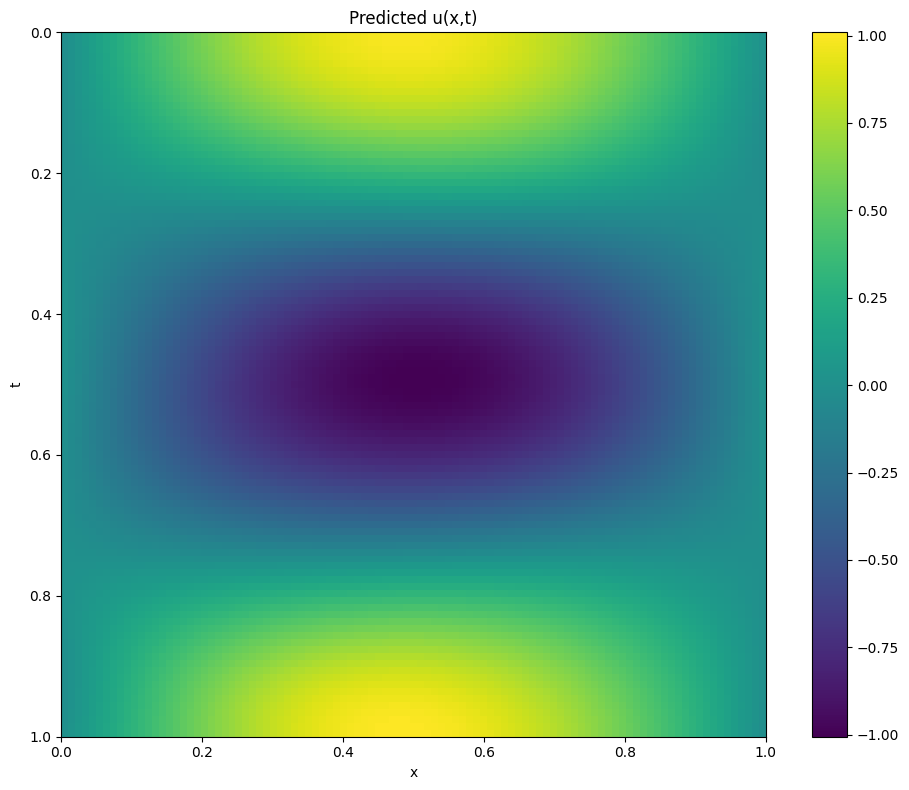

In [ ]:
#Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)



res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(10,8))
plt.imshow(pred, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinns_pred.png')
plt.show()

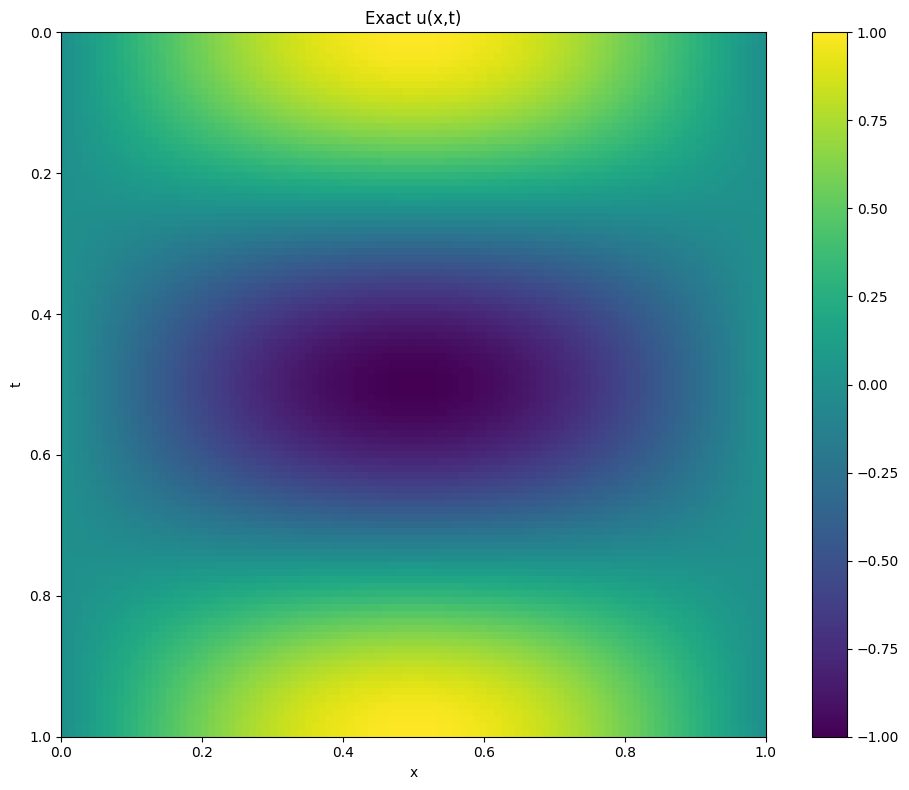

In [97]:
plt.figure(figsize=(10,8))
plt.imshow(u, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

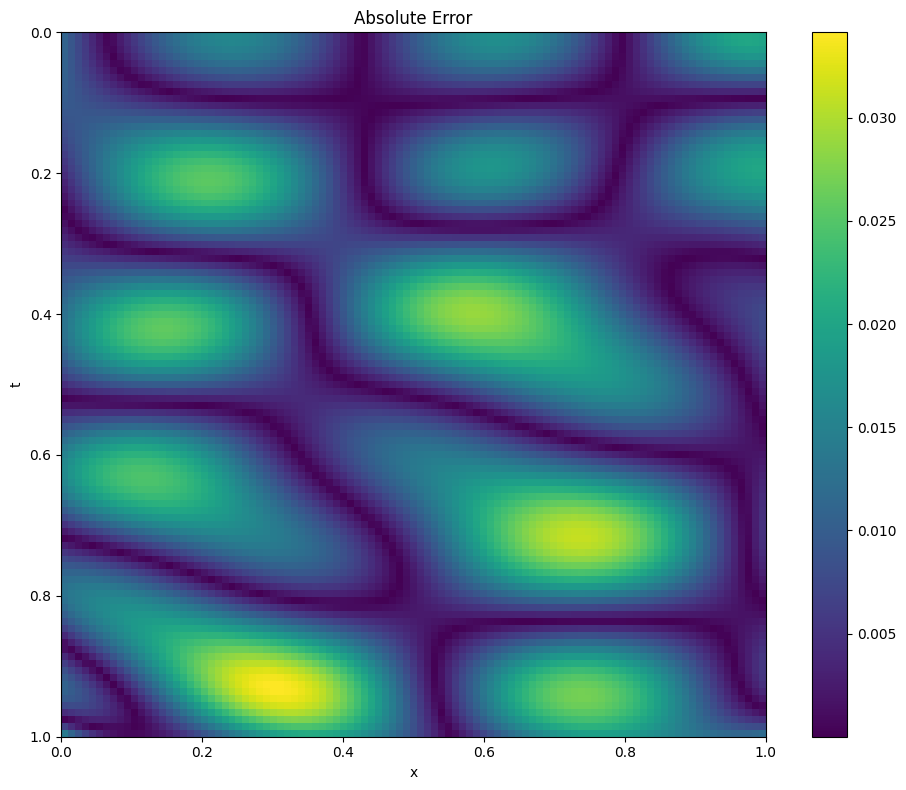

In [98]:
plt.figure(figsize=(10,8))
plt.imshow(np.abs(pred - u), extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()